In [1]:
# import sys
# import os

# print(sys.path)

# sys.path.append(os.path.normpath('C:/Users/bheineike/Documents/GitHub/diverse_yeast'))

In [2]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
from collections import Counter
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings
import scipy.stats as stats
from Bio import SeqIO, AlignIO, pairwise2, SeqUtils

# yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")
# if yeast_esr_flag=='Y':
#     yeast_esr_exp_path = os.path.normpath('C:/Users/bheineike/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
#     #io_library_path_core = io_library_path + 'core' + os.sep
#     if not(yeast_esr_exp_path in sys.path):
#         sys.path.append(yeast_esr_exp_path)
#         print("Added " + yeast_esr_exp_path + " to path" )
#     from yeast_esr_exp import read_SGD_features
#     #yeast_esr_exp.base_dir = yeast_esr_exp_path
#     #yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep


#from Bio import AlignIO   #, Align
#import shutil


base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')

summary_data_dir = base_dir + os.sep + os.path.normpath('/Output/Summary')

#Load dictionary to translate 3 letter aa code to 1 letter aa code
trans_dict = SeqUtils.IUPACData.protein_letters_3to1

#SC_orfs_lookup, SC_genename_lookup, SC_features_lookup = read_SGD_features(sgd_features_fname='G:/My Drive/Crick_LMS/external_data/genomes/saccharomyces_cerevisiae/SGD_features.tab')

In [2]:
# First Feature:  Binding Site
feature='binding_site'
min_feature_size = 5
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep


In [23]:
# Trim Alignment by Structural Feature

#  Note:  Need to make fasta_renamed and cds_align folders before running this
#  This routine makes alignments (stored in feature_subsets/<feature>/fasta_renamed) and cds alignments (stored in feature_subsets/<feature>/cds_aln) for just the specified feature

#Example OG1316_REF_Scer_AF-P19097-F1-model_v2 -- FAS2 as it is an enzyme with a less conserved binding site
#og_ref = 'OG1316_REF_Scer_AF-P19097-F1-model_v2'

feature_sizes = {}


for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    og_ref = fasta_file.split('.')[0]
    print(og_ref)

    ref = '_'.join(og_ref.split('_')[1:])
     
    
    if ref+'.pkl' in os.listdir(summary_data_dir): 
        #Load Summary data for given og_ref
        og_summary_fname = summary_data_dir + os.sep + ref + '.pkl'
        with open(og_summary_fname, 'rb') as f_in:
                og_summary = pickle.load(f_in)

        #Check to see if the feature exists for that protein
        if 'Binding Site' in set(og_summary['Mapping Colors'].keys()):

            aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
            aln = AlignIO.read(open(aln_fname),'fasta')

            aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
            aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')


            #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates

            ref_ind=None
            for (jj, record) in enumerate(aln): 
                if ref == record.id.split('.')[0]:
                    ref_ind = jj

            #Get map for reference sequence from msa index
            ref_seq_from_msa = str(aln[ref_ind,:].seq)
            ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)


            #Get list of indices for the feature   
            feat_inds_ref = []
            for jj, feature_present in enumerate((og_summary['Mapping Colors']['Binding Site']==1)): 
                if feature_present:
                    feat_inds_ref.append(jj)

            feature_size = len(feat_inds_ref)
            feature_sizes[og_ref] = feature_size

            if feature_size>= min_feature_size: 
                feat_inds_msa = []


                for feat_ind in feat_inds_ref: 
                    feat_inds_msa.append(ref2msa[feat_ind])

                    #Verify seq_squeeze is mapping correctly
                    assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"

                    #Verify identical sequence in tm_align reference and in Output/Summary data
                    aa_3L_caps = og_summary['Mapping']['Amino Acid'][0,:][feat_ind]
                    aa_3L = aa_3L_caps[0] + aa_3L_caps[1:].lower()
                    trans_dict[aa_3L]
                    assert (ref_seq[feat_ind] == trans_dict[aa_3L]), "Difference in sequence between tm_align alignment and Output/Summary data: " + og_ref + ' ' + str(feat_ind) + ' ' + ref_seq[feat_ind] + ' vs ' + aa3L 

                #Extract Alignment Subsets
                #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
                #Converts alignment to numpy array then converts back to aln object

                aln_temp = aln[:,0:0]
                aln_cds_temp = aln_cds[:,0:0]

                for x in feat_inds_msa:
                    aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
                    aln_temp = aln_subset

                    aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                    aln_cds_temp = aln_cds_subset

                #Save alignment subset
                aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                with open(aln_subset_fname_out,'w') as f_out: 
                    for record in aln_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')

                aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                with open(aln_cds_subset_fname_out,'w') as f_out: 
                    for record in aln_cds_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')
            else: 
                print(feature + ' size of ' + str(feature_size) + ' below threshold size of ' + str(min_feature_size))

        else: 
            print('No ' + feature + ' for ' + og_ref)
    
    else: 
        print('No .pkl file for ' + og_ref)

OG1022_REF_Scer_AF-P49954-F1-model_v2
No uniprot_active_site for OG1022_REF_Scer_AF-P49954-F1-model_v2
OG1056_REF_Scer_AF-P21954-F1-model_v2


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\Crick_LMS\\projects\\diverse_yeasts\\alphafold\\msas\\structural\\tm_align\\feature_subsets\\uniprot_active_site\\fasta_renamed\\OG1056_REF_Scer_AF-P21954-F1-model_v2.tm.fasta'

In [63]:
with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'wb') as f_out: 
    pickle.dump(feature_sizes, f_out)

In [60]:
feature_sizes = {'OG1004_REF_Scer_AF-P15938-F1-model_v2': 45,
 'OG1004_REF_Scer_AF-P40459-F1-model_v2': 18,
 'OG1054_REF_Scer_AF-P16861-F1-model_v2': 31,
 'OG1055_REF_Scer_AF-P52910-F1-model_v2': 22,
 'OG1056_REF_Scer_AF-P21954-F1-model_v2': 43,
 'OG1060_REF_Scer_AF-P06169-F1-model_v2': 56,
 'OG1060_REF_Scer_AF-P50873-F1-model_v2': 131,
 'OG1070_REF_Scer_AF-P21524-F1-model_v2': 89,
 'OG1112_REF_Scer_AF-P23254-F1-model_v2': 39,
 'OG1145_REF_Scer_AF-P00358-F1-model_v2': 37,
 'OG1180_REF_Scer_AF-P41903-F1-model_v2': 8,
 'OG1193_REF_Scer_AF-P00924-F1-model_v2': 38,
 'OG1208_REF_Scer_AF-P04806-F1-model_v2': 15,
 'OG1266_REF_Scer_AF-P23337-F1-model_v2': 92,
 'OG1299_REF_Scer_AF-P00549-F1-model_v2': 41,
 'OG1310_REF_Scer_AF-P15202-F1-model_v2': 34,
 'OG1316_REF_Scer_AF-P19097-F1-model_v2': 95,
 'OG1364_REF_Scer_AF-P27796-F1-model_v2': 26,
 'OG1365_REF_Scer_AF-P29509-F1-model_v2': 69,
 'OG1377_REF_Scer_AF-P53090-F1-model_v2': 28,
 'OG1388_REF_Scer_AF-P07342-F1-model_v2': 101,
 'OG1414_REF_Scer_AF-P06700-F1-model_v2': 54,
 'OG1424_REF_Scer_AF-P00560-F1-model_v2': 74,
 'OG1451_REF_Scer_AF-P38998-F1-model_v2': 45,
 'OG1463_REF_Scer_AF-P07149-F1-model_v2': 33,
 'OG1487_REF_Scer_AF-P09938-F1-model_v2': 7,
 'OG1488_REF_Scer_AF-P38720-F1-model_v2': 18,
 'OG1537_REF_Scer_AF-P32288-F1-model_v2': 14,
 'OG1567_REF_Scer_AF-P17695-F1-model_v2': 18,
 'OG1603_REF_Scer_AF-P16120-F1-model_v2': 20,
 'OG1603_REF_Scer_AF-P25632-F1-model_v2': 3,
 'OG1629_REF_Scer_AF-P09624-F1-model_v2': 69,
 'OG1630_REF_Scer_AF-P50264-F1-model_v2': 77,
 'OG1631_REF_Scer_AF-P22217-F1-model_v2': 13,
 'OG1650_REF_Scer_AF-P23542-F1-model_v2': 28,
 'OG1667_REF_Scer_AF-P15019-F1-model_v2': 91,
 'OG1674_REF_Scer_AF-P13298-F1-model_v2': 23,
 'OG1684_REF_Scer_AF-P41921-F1-model_v2': 100,
 'OG1767_REF_Scer_AF-P05373-F1-model_v2': 37,
 'OG1786_REF_Scer_AF-P28241-F1-model_v2': 5,
 'OG1807_REF_Scer_AF-Q05871-F1-model_v2': 60,
 'OG1810_REF_Scer_AF-P31116-F1-model_v2': 37,
 'OG1822_REF_Scer_AF-P43616-F1-model_v2': 9,
 'OG1835_REF_Scer_AF-P17505-F1-model_v2': 6,
 'OG1933_REF_Scer_AF-P40545-F1-model_v2': 28,
 'OG1975_REF_Scer_AF-P15454-F1-model_v2': 8,
 'OG1979_REF_Scer_AF-P00445-F1-model_v2': 16,
 'OG2006_REF_Scer_AF-P07257-F1-model_v2': 0,
 'OG2031_REF_Scer_AF-Q08220-F1-model_v2': 43,
 'OG2074_REF_Scer_AF-Q02046-F1-model_v2': 21,
 'OG2186_REF_Scer_AF-P32477-F1-model_v2': 67,
 'OG2197_REF_Scer_AF-P00942-F1-model_v2': 45,
 'OG2248_REF_Scer_AF-P07143-F1-model_v2': 68,
 'OG2356_REF_Scer_AF-P33312-F1-model_v2': 31,
 'OG2357_REF_Scer_AF-P33734-F1-model_v2': 33,
 'OG2365_REF_Scer_AF-P08536-F1-model_v2': 116,
 'OG2380_REF_Scer_AF-P53848-F1-model_v2': 36,
 'OG2453_REF_Scer_AF-P27616-F1-model_v2': 81,
 'OG2537_REF_Scer_AF-P11353-F1-model_v2': 9,
 'OG2573_REF_Scer_AF-P38075-F1-model_v2': 24,
 'OG2654_REF_Scer_AF-P00572-F1-model_v2': 31,
 'OG2677_REF_Scer_AF-P28834-F1-model_v2': 24,
 'OG2740_REF_Scer_AF-P07170-F1-model_v2': 53,
 'OG2765_REF_Scer_AF-Q3E840-F1-model_v2': 11,
 'OG2794_REF_Scer_AF-P00950-F1-model_v2': 21,
 'OG2841_REF_Scer_AF-P06738-F1-model_v2': 19,
 'OG2845_REF_Scer_AF-P43577-F1-model_v2': 31,
 'OG2871_REF_Scer_AF-P18408-F1-model_v2': 29,
 'OG2906_REF_Scer_AF-P32178-F1-model_v2': 15,
 'OG2960_REF_Scer_AF-P16622-F1-model_v2': 4,
 'OG3001_REF_Scer_AF-P15807-F1-model_v2': 23,
 'OG3074_REF_Scer_AF-P38913-F1-model_v2': 27,
 'OG3114_REF_Scer_AF-P35202-F1-model_v2': 13,
 'OG3185_REF_Scer_AF-P00447-F1-model_v2': 9,
 'OG3208_REF_Scer_AF-P00128-F1-model_v2': 3,
 'OG3214_REF_Scer_AF-P11986-F1-model_v2': 56,
 'OG3241_REF_Scer_AF-P40363-F1-model_v2': 4,
 'OG3319_REF_Scer_AF-P32626-F1-model_v2': 23,
 'OG3336_REF_Scer_AF-P43567-F1-model_v2': 19,
 'OG3394_REF_Scer_AF-Q03266-F1-model_v2': 21,
 'OG3488_REF_Scer_AF-P53184-F1-model_v2': 13,
 'OG3505_REF_Scer_AF-P04037-F1-model_v2': 11,
 'OG3509_REF_Scer_AF-P43619-F1-model_v2': 25,
 'OG3575_REF_Scer_AF-P08067-F1-model_v2': 30,
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2': 47,
 'OG3702_REF_Scer_AF-P03962-F1-model_v2': 29,
 'OG3767_REF_Scer_AF-P39683-F1-model_v2': 0,
 'OG3935_REF_Scer_AF-P38169-F1-model_v2': 41,
 'OG3978_REF_Scer_AF-P31373-F1-model_v2': 20,
 'OG3994_REF_Scer_AF-P04397-F1-model_v2': 67,
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2': 25,
 'OG4010_REF_Scer_AF-P50861-F1-model_v2': 27,
 'OG4102_REF_Scer_AF-P47096-F1-model_v2': 13,
 'OG4150_REF_Scer_AF-P07256-F1-model_v2': 9,
 'OG4231_REF_Scer_AF-P04385-F1-model_v2': 43,
 'OG4250_REF_Scer_AF-P35731-F1-model_v2': 43,
 'OG4312_REF_Scer_AF-P38115-F1-model_v2': 33,
 'OG4312_REF_Scer_AF-P38280-F1-model_v2': 26,
 'OG4352_REF_Scer_AF-P00127-F1-model_v2': 17,
 'OG4360_REF_Scer_AF-P08525-F1-model_v2': 7,
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2': 6,
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2': 31,
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2': 13,
 'OG4665_REF_Scer_AF-P32449-F1-model_v2': 48,
 'OG4744_REF_Scer_AF-P22289-F1-model_v2': 12,
 'OG5096_REF_Scer_AF-P42883-F1-model_v2': 0,
 'OG5490_REF_Scer_AF-P32340-F1-model_v2': 138}

In [7]:
print(str(len(feature_sizes)) + " files that had binding sites identified")
print(str(len([feature for feature, size in feature_sizes.items() if size >= min_feature_size])) + " binding sites with binding site size greater than " + str(min_feature_size))

107 files that had binding sites identified
100 binding sites with binding site size greater than 5


## Calculate M0 for Binding sites as defined by Uniprot

In [64]:
# Second Feature:  Uniprot Binding Site
feature=  'uniprot_binding_site' #'uniprot_active_site' #
min_feature_size = 5
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

In [27]:
uniprot_data_fname = base_dir + os.sep + os.path.normpath('external_data/enzymatic_data_from_uniprot.pkl')

with open(uniprot_data_fname, 'rb') as f_in:
    uniprot_data = pickle.load(f_in)

feature_sizes = {}

for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    og_ref = fasta_file.split('.')[0]
    
    if og_ref.split('_')[1]=='REF':
        uniprot_id = og_ref.split('_')[3].split('-')[1]
        
        ref = '_'.join(og_ref.split('_')[1:])
        
        #Identify coordinates in alignment for binding site
              
        #Check to see if there is a binding site listed
        
        uniprot_data_ref = uniprot_data[uniprot_id]
        
        bs_indicator_vec = uniprot_data_ref[1]
        if bs_indicator_vec[0] == 'NaN': 
            print(og_ref + ' removed because NaN present in uniprot data')

        else: 
            bs_size = sum(bs_indicator_vec)
            feature_sizes[og_ref]= bs_size

            if bs_size>0:
                if bs_size < min_feature_size: 
                    print(og_ref + ' removed because feature size < min feature size of ' + str(min_feature_size))
                else:  
                    print('building feature alignment for ' + og_ref)
                    #Binding site is present and larger than min feature size. 
                    #Identify coordinates within the alignment
                    
                    #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates
                    aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
                    aln = AlignIO.read(open(aln_fname),'fasta')

                    aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                    aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')
                                      
                    ref_ind=None
                    for (jj, record) in enumerate(aln): 
                        if ref == record.id.split('.')[0]:
                            ref_ind = jj

                    #Get map for reference sequence from msa index
                    ref_seq_from_msa = str(aln[ref_ind,:].seq)
                    ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)
                    
                    assert ref_seq == uniprot_data_ref[3], 'Sequence mismatch between uniprot data file and alignment'
                    
                    
                    #Get list of indices for the feature   
                    feat_inds_ref = []
                    for jj, feature_present in enumerate(bs_indicator_vec==1): 
                        if feature_present:
                            feat_inds_ref.append(jj)
                    
                    feat_inds_msa = []


                    for feat_ind in feat_inds_ref: 
                        feat_inds_msa.append(ref2msa[feat_ind])
                        
                    

                    #Verify seq_squeeze is mapping correctly
                    assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"
                    
                    #Extract Alignment Subsets
                    #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
                    #Converts alignment to numpy array then converts back to aln object

                    aln_temp = aln[:,0:0]
                    aln_cds_temp = aln_cds[:,0:0]

                    for x in feat_inds_msa:
                        aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
                        aln_temp = aln_subset
                        
                        aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                        aln_cds_temp = aln_cds_subset

                    #Save alignment subset
                    aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                    with open(aln_subset_fname_out,'w') as f_out: 
                        for record in aln_subset:
                            f_out.write('>' + record.id + '\n')   # Could add a length to this
                            f_out.write(str(record.seq) + '\n')

                    aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                    with open(aln_cds_subset_fname_out,'w') as f_out: 
                        for record in aln_cds_subset:
                            f_out.write('>' + record.id + '\n')   # Could add a length to this
                            f_out.write(str(record.seq) + '\n')
                    

building feature alignment for OG1056_REF_Scer_AF-P21954-F1-model_v2
building feature alignment for OG1055_REF_Scer_AF-P52910-F1-model_v2
building feature alignment for OG1039_REF_Scer_AF-P19414-F1-model_v2
building feature alignment for OG1016_REF_Scer_AF-P00330-F1-model_v2
building feature alignment for OG1087_REF_Scer_AF-P39518-F1-model_v2
building feature alignment for OG1032_REF_Scer_AF-P03965-F1-model_v2
building feature alignment for OG1022_REF_Scer_AF-P38715-F1-model_v2
OG1052_REF_Scer_AF-P07245-F1-model_v2 removed because NaN present in uniprot data
building feature alignment for OG1021_REF_Scer_AF-P40047-F1-model_v2
OG1157_REF_Scer_AF-P17649-F1-model_v2 removed because feature size < min feature size of 5
building feature alignment for OG1145_REF_Scer_AF-P00358-F1-model_v2
building feature alignment for OG1193_REF_Scer_AF-P00924-F1-model_v2
OG1111_REF_Scer_AF-P49367-F1-model_v2 removed because feature size < min feature size of 5
building feature alignment for OG1208_REF_Scer

In [49]:
with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'wb') as f_out: 
    pickle.dump(feature_sizes, f_out)

In [29]:
feature_sizes = {'OG1022_REF_Scer_AF-P49954-F1-model_v2': 0,
 'OG1056_REF_Scer_AF-P21954-F1-model_v2': 21,
 'OG1055_REF_Scer_AF-P52910-F1-model_v2': 16,
 'OG1103_REF_Scer_AF-P47771-F1-model_v2': 0,
 'OG1039_REF_Scer_AF-P19414-F1-model_v2': 10,
 'OG1016_REF_Scer_AF-P00330-F1-model_v2': 18,
 'OG1087_REF_Scer_AF-P39518-F1-model_v2': 11,
 'OG1032_REF_Scer_AF-P03965-F1-model_v2': 110,
 'OG1030_REF_Scer_AF-P37291-F1-model_v2': 0,
 'OG1022_REF_Scer_AF-P38715-F1-model_v2': 68,
 'OG1004_REF_Scer_AF-P40459-F1-model_v2': 0,
 'OG1021_REF_Scer_AF-P40047-F1-model_v2': 5,
 'OG1157_REF_Scer_AF-P17649-F1-model_v2': 3,
 'OG1145_REF_Scer_AF-P00358-F1-model_v2': 9,
 'OG1210_REF_Scer_AF-P38891-F1-model_v2': 0,
 'OG1193_REF_Scer_AF-P00924-F1-model_v2': 9,
 'OG1126_REF_Scer_AF-P38067-F1-model_v2': 0,
 'OG1121_REF_Scer_AF-P53045-F1-model_v2': 0,
 'OG1111_REF_Scer_AF-P49367-F1-model_v2': 3,
 'OG1170_REF_Scer_AF-P21826-F1-model_v2': 0,
 'OG1180_REF_Scer_AF-P41903-F1-model_v2': 0,
 'OG1208_REF_Scer_AF-P04806-F1-model_v2': 21,
 'OG1137_REF_Scer_AF-P41911-F1-model_v2': 11,
 'OG1112_REF_Scer_AF-P23254-F1-model_v2': 16,
 'OG1129_REF_Scer_AF-P37303-F1-model_v2': 0,
 'OG1275_REF_Scer_AF-P47052-F1-model_v2': 27,
 'OG1316_REF_Scer_AF-P19097-F1-model_v2': 21,
 'OG1276_REF_Scer_AF-P36013-F1-model_v2': 4,
 'OG1310_REF_Scer_AF-P15202-F1-model_v2': 1,
 'OG1218_REF_Scer_AF-P08417-F1-model_v2': 11,
 'OG1299_REF_Scer_AF-P00549-F1-model_v2': 21,
 'OG1313_REF_Scer_AF-P11154-F1-model_v2': 12,
 'OG1302_REF_Scer_AF-P33401-F1-model_v2': 10,
 'OG1240_REF_Scer_AF-P30624-F1-model_v2': 11,
 'OG1266_REF_Scer_AF-P23337-F1-model_v2': 1,
 'OG1242_REF_Scer_AF-P36107-F1-model_v2': 0,
 'OG1306_REF_Scer_AF-P38298-F1-model_v2': 0,
 'OG1273_REF_Scer_AF-P40012-F1-model_v2': 13,
 'OG1264_REF_Scer_AF-P52892-F1-model_v2': 0,
 'OG1318_REF_Scer_AF-Q06147-F1-model_v2': 13,
 'OG1414_REF_Scer_AF-P06700-F1-model_v2': 31,
 'OG1355_REF_Scer_AF-P10614-F1-model_v2': 3,
 'OG1333_REF_Scer_AF-P11412-F1-model_v2': 17,
 'OG1364_REF_Scer_AF-P27796-F1-model_v2': 0,
 'OG1422_REF_Scer_AF-P07264-F1-model_v2': 3,
 'OG1388_REF_Scer_AF-P07342-F1-model_v2': 45,
 'OG1390_REF_Scer_AF-P47164-F1-model_v2': 0,
 'OG1354_REF_Scer_AF-P38697-F1-model_v2': 19,
 'OG1380_REF_Scer_AF-Q07729-F1-model_v2': 9,
 'OG1357_REF_Scer_AF-P14742-F1-model_v2': 0,
 'OG1337_REF_Scer_AF-P32356-F1-model_v2': 13,
 'OG1329_REF_Scer_AF-P17709-F1-model_v2': 6,
 'OG1416_REF_Scer_AF-P00890-F1-model_v2': 0,
 'OG1365_REF_Scer_AF-P29509-F1-model_v2': 11,
 'OG1446_REF_Scer_AF-P41940-F1-model_v2': 0,
 'OG1470_REF_Scer_AF-P21147-F1-model_v2': 11,
 'OG1473_REF_Scer_AF-P53204-F1-model_v2': 13,
 'OG1487_REF_Scer_AF-P09938-F1-model_v2': 6,
 'OG1488_REF_Scer_AF-P38720-F1-model_v2': 18,
 'OG1445_REF_Scer_AF-P39522-F1-model_v2': 6,
 'OG1458_REF_Scer_AF-Q08911-F1-model_v2': 13,
 'OG1433_REF_Scer_AF-P40054-F1-model_v2': 8,
 'OG1432_REF_Scer_AF-P14540-F1-model_v2': 12,
 'OG1497_REF_Scer_AF-P38143-F1-model_v2': 0,
 'OG1468_REF_Scer_AF-P17898-F1-model_v2': 0,
 'OG1451_REF_Scer_AF-P38998-F1-model_v2': 16,
 'OG1424_REF_Scer_AF-P00560-F1-model_v2': 15,
 'OG1471_REF_Scer_AF-P33333-F1-model_v2': 0,
 'OG1491_REF_Scer_AF-P40506-F1-model_v2': 0,
 'OG1463_REF_Scer_AF-P07149-F1-model_v2': 0,
 'OG1434_REF_Scer_AF-P25340-F1-model_v2': 10,
 'OG1567_REF_Scer_AF-P17695-F1-model_v2': 7,
 'OG1521_REF_Scer_AF-P32771-F1-model_v2': 20,
 'OG1556_REF_Scer_AF-P32895-F1-model_v2': 3,
 'OG1589_REF_Scer_AF-Q12680-F1-model_v2': 73,
 'OG1615_REF_Scer_AF-P38992-F1-model_v2': 0,
 'OG1603_REF_Scer_AF-P16120-F1-model_v2': 0,
 'OG1516_REF_Scer_AF-P10659-F1-model_v2': 15,
 'OG1596_REF_Scer_AF-P54781-F1-model_v2': 1,
 'OG1502_REF_Scer_AF-P33300-F1-model_v2': 0,
 'OG1564_REF_Scer_AF-P08019-F1-model_v2': 1,
 'OG1500_REF_Scer_AF-P28274-F1-model_v2': 0,
 'OG1537_REF_Scer_AF-P32288-F1-model_v2': 0,
 'OG1595_REF_Scer_AF-P07275-F1-model_v2': 5,
 'OG1585_REF_Scer_AF-P20967-F1-model_v2': 0,
 'OG1498_REF_Scer_AF-Q06702-F1-model_v2': 5,
 'OG1565_REF_Scer_AF-P38604-F1-model_v2': 0,
 'OG1597_REF_Scer_AF-P47169-F1-model_v2': 4,
 'OG1569_REF_Scer_AF-P06168-F1-model_v2': 23,
 'OG1630_REF_Scer_AF-P50264-F1-model_v2': 0,
 'OG1617_REF_Scer_AF-P05150-F1-model_v2': 12,
 'OG1622_REF_Scer_AF-P15274-F1-model_v2': 13,
 'OG1694_REF_Scer_AF-P39713-F1-model_v2': 6,
 'OG1659_REF_Scer_AF-P32775-F1-model_v2': 0,
 'OG1640_REF_Scer_AF-P23501-F1-model_v2': 0,
 'OG1673_REF_Scer_AF-P16661-F1-model_v2': 0,
 'OG1665_REF_Scer_AF-P10869-F1-model_v2': 0,
 'OG1671_REF_Scer_AF-P32861-F1-model_v2': 11,
 'OG1674_REF_Scer_AF-P13298-F1-model_v2': 16,
 'OG1629_REF_Scer_AF-P09624-F1-model_v2': 27,
 'OG1634_REF_Scer_AF-P31688-F1-model_v2': 0,
 'OG1685_REF_Scer_AF-P07991-F1-model_v2': 0,
 'OG1667_REF_Scer_AF-P15019-F1-model_v2': 0,
 'OG1684_REF_Scer_AF-P41921-F1-model_v2': 53,
 'OG1650_REF_Scer_AF-P23542-F1-model_v2': 4,
 'OG1683_REF_Scer_AF-P40970-F1-model_v2': 0,
 'OG1695_REF_Scer_AF-P38221-F1-model_v2': 0,
 'OG1730_REF_Scer_AF-P25087-F1-model_v2': 0,
 'OG1753_REF_Scer_AF-Q00764-F1-model_v2': 14,
 'OG1767_REF_Scer_AF-P05373-F1-model_v2': 7,
 'OG1779_REF_Scer_AF-P38625-F1-model_v2': 6,
 'OG1744_REF_Scer_AF-P32264-F1-model_v2': 10,
 'OG1774_REF_Scer_AF-P38972-F1-model_v2': 19,
 'OG1788_REF_Scer_AF-P00927-F1-model_v2': 0,
 'OG1696_REF_Scer_AF-P53598-F1-model_v2': 7,
 'OG1697_REF_Scer_AF-P32469-F1-model_v2': 7,
 'OG1786_REF_Scer_AF-P28241-F1-model_v2': 6,
 'OG1785_REF_Scer_AF-P25578-F1-model_v2': 7,
 'OG1764_REF_Scer_AF-Q12189-F1-model_v2': 0,
 'OG1759_REF_Scer_AF-P47039-F1-model_v2': 0,
 'OG1724_REF_Scer_AF-P00931-F1-model_v2': 0,
 'OG1815_REF_Scer_AF-P09201-F1-model_v2': 29,
 'OG1880_REF_Scer_AF-P29952-F1-model_v2': 4,
 'OG1899_REF_Scer_AF-P09950-F1-model_v2': 9,
 'OG1810_REF_Scer_AF-P31116-F1-model_v2': 10,
 'OG1857_REF_Scer_AF-P38795-F1-model_v2': 7,
 'OG1835_REF_Scer_AF-P17505-F1-model_v2': 15,
 'OG1892_REF_Scer_AF-P07262-F1-model_v2': 29,
 'OG1819_REF_Scer_AF-P04046-F1-model_v2': 2,
 'OG1807_REF_Scer_AF-Q05871-F1-model_v2': 5,
 'OG1822_REF_Scer_AF-P43616-F1-model_v2': 5,
 'OG1854_REF_Scer_AF-P40487-F1-model_v2': 3,
 'OG1813_REF_Scer_AF-P05694-F1-model_v2': 14,
 'OG1897_REF_Scer_AF-P41338-F1-model_v2': 7,
 'OG1881_REF_Scer_AF-P10963-F1-model_v2': 7,
 'OG1883_REF_Scer_AF-P13663-F1-model_v2': 11,
 'OG2007_REF_Scer_AF-Q12265-F1-model_v2': 4,
 'OG1959_REF_Scer_AF-P32473-F1-model_v2': 1,
 'OG2031_REF_Scer_AF-Q08220-F1-model_v2': 31,
 'OG1924_REF_Scer_AF-P19262-F1-model_v2': 0,
 'OG1979_REF_Scer_AF-P00445-F1-model_v2': 9,
 'OG1933_REF_Scer_AF-P40545-F1-model_v2': 0,
 'OG1904_REF_Scer_AF-P54839-F1-model_v2': 0,
 'OG1935_REF_Scer_AF-P38999-F1-model_v2': 15,
 'OG1944_REF_Scer_AF-P06106-F1-model_v2': 0,
 'OG1977_REF_Scer_AF-P38066-F1-model_v2': 13,
 'OG1966_REF_Scer_AF-P36150-F1-model_v2': 0,
 'OG1975_REF_Scer_AF-P15454-F1-model_v2': 16,
 'OG2028_REF_Scer_AF-P00899-F1-model_v2': 11,
 'OG2057_REF_Scer_AF-P28789-F1-model_v2': 0,
 'OG2086_REF_Scer_AF-P80210-F1-model_v2': 25,
 'OG2056_REF_Scer_AF-P20051-F1-model_v2': 6,
 'OG2071_REF_Scer_AF-P12695-F1-model_v2': 0,
 'OG2038_REF_Scer_AF-P12709-F1-model_v2': 10,
 'OG2099_REF_Scer_AF-P28240-F1-model_v2': 10,
 'OG2048_REF_Scer_AF-P33412-F1-model_v2': 0,
 'OG2074_REF_Scer_AF-Q02046-F1-model_v2': 4,
 'OG2062_REF_Scer_AF-P32347-F1-model_v2': 10,
 'OG2032_REF_Scer_AF-P14843-F1-model_v2': 0,
 'OG2098_REF_Scer_AF-P32462-F1-model_v2': 11,
 'OG2082_REF_Scer_AF-P28777-F1-model_v2': 0,
 'OG2061_REF_Scer_AF-Q99258-F1-model_v2': 7,
 'OG2044_REF_Scer_AF-P38225-F1-model_v2': 11,
 'OG2053_REF_Scer_AF-P21264-F1-model_v2': 55,
 'OG2116_REF_Scer_AF-P53199-F1-model_v2': 15,
 'OG2190_REF_Scer_AF-Q04430-F1-model_v2': 0,
 'OG2183_REF_Scer_AF-P27515-F1-model_v2': 7,
 'OG2186_REF_Scer_AF-P32477-F1-model_v2': 0,
 'OG2129_REF_Scer_AF-P06785-F1-model_v2': 9,
 'OG2126_REF_Scer_AF-Q08645-F1-model_v2': 8,
 'OG2147_REF_Scer_AF-P39692-F1-model_v2': 21,
 'OG2123_REF_Scer_AF-P32378-F1-model_v2': 0,
 'OG2214_REF_Scer_AF-P13259-F1-model_v2': 16,
 'OG2197_REF_Scer_AF-P00942-F1-model_v2': 2,
 'OG2218_REF_Scer_AF-P20049-F1-model_v2': 29,
 'OG2182_REF_Scer_AF-P20485-F1-model_v2': 0,
 'OG2161_REF_Scer_AF-P46969-F1-model_v2': 11,
 'OG2148_REF_Scer_AF-Q05911-F1-model_v2': 9,
 'OG2156_REF_Scer_AF-P08524-F1-model_v2': 12,
 'OG2215_REF_Scer_AF-P39525-F1-model_v2': 0,
 'OG2308_REF_Scer_AF-Q07938-F1-model_v2': 7,
 'OG2228_REF_Scer_AF-P53037-F1-model_v2': 3,
 'OG2227_REF_Scer_AF-P49095-F1-model_v2': 0,
 'OG2265_REF_Scer_AF-P07286-F1-model_v2': 16,
 'OG2282_REF_Scer_AF-P49435-F1-model_v2': 4,
 'OG2283_REF_Scer_AF-Q04212-F1-model_v2': 67,
 'OG2246_REF_Scer_AF-P46151-F1-model_v2': 16,
 'OG2248_REF_Scer_AF-P07143-F1-model_v2': 4,
 'OG2238_REF_Scer_AF-P07172-F1-model_v2': 0,
 'OG2353_REF_Scer_AF-P32352-F1-model_v2': 0,
 'OG2262_REF_Scer_AF-P37254-F1-model_v2': 0,
 'OG2347_REF_Scer_AF-P07283-F1-model_v2': 12,
 'OG2369_REF_Scer_AF-P38145-F1-model_v2': 19,
 'OG2356_REF_Scer_AF-P33312-F1-model_v2': 7,
 'OG2465_REF_Scer_AF-P32353-F1-model_v2': 0,
 'OG2382_REF_Scer_AF-P25045-F1-model_v2': 0,
 'OG2384_REF_Scer_AF-P47143-F1-model_v2': 0,
 'OG2455_REF_Scer_AF-P32190-F1-model_v2': 11,
 'OG2397_REF_Scer_AF-P32796-F1-model_v2': 12,
 'OG2365_REF_Scer_AF-P08536-F1-model_v2': 8,
 'OG2453_REF_Scer_AF-P27616-F1-model_v2': 0,
 'OG2394_REF_Scer_AF-P39006-F1-model_v2': 0,
 'OG2498_REF_Scer_AF-P29704-F1-model_v2': 0,
 'OG2495_REF_Scer_AF-P53128-F1-model_v2': 16,
 'OG2357_REF_Scer_AF-P33734-F1-model_v2': 3,
 'OG2409_REF_Scer_AF-P53312-F1-model_v2': 9,
 'OG2578_REF_Scer_AF-Q03941-F1-model_v2': 7,
 'OG2557_REF_Scer_AF-Q05567-F1-model_v2': 0,
 'OG2629_REF_Scer_AF-P09368-F1-model_v2': 0,
 'OG2552_REF_Scer_AF-P32263-F1-model_v2': 0,
 'OG2588_REF_Scer_AF-P38063-F1-model_v2': 4,
 'OG2562_REF_Scer_AF-Q99190-F1-model_v2': 0,
 'OG2506_REF_Scer_AF-P54783-F1-model_v2': 0,
 'OG2537_REF_Scer_AF-P11353-F1-model_v2': 8,
 'OG2573_REF_Scer_AF-P38075-F1-model_v2': 18,
 'OG2567_REF_Scer_AF-P24521-F1-model_v2': 10,
 'OG2603_REF_Scer_AF-P50076-F1-model_v2': 0,
 'OG2508_REF_Scer_AF-Q12074-F1-model_v2': 10,
 'OG2704_REF_Scer_AF-P21801-F1-model_v2': 12,
 'OG2647_REF_Scer_AF-P38787-F1-model_v2': 10,
 'OG2684_REF_Scer_AF-P41735-F1-model_v2': 6,
 'OG2721_REF_Scer_AF-P07258-F1-model_v2': 0,
 'OG2645_REF_Scer_AF-P05375-F1-model_v2': 3,
 'OG2677_REF_Scer_AF-P28834-F1-model_v2': 3,
 'OG2655_REF_Scer_AF-P06633-F1-model_v2': 27,
 'OG2678_REF_Scer_AF-P07277-F1-model_v2': 10,
 'OG2654_REF_Scer_AF-P00572-F1-model_v2': 7,
 'OG2637_REF_Scer_AF-P80235-F1-model_v2': 15,
 'OG2646_REF_Scer_AF-P53730-F1-model_v2': 0,
 'OG2794_REF_Scer_AF-P00950-F1-model_v2': 15,
 'OG2746_REF_Scer_AF-P40495-F1-model_v2': 17,
 'OG2740_REF_Scer_AF-P07170-F1-model_v2': 18,
 'OG2808_REF_Scer_AF-P40471-F1-model_v2': 8,
 'OG2837_REF_Scer_AF-Q02196-F1-model_v2': 7,
 'OG2807_REF_Scer_AF-P16387-F1-model_v2': 0,
 'OG2841_REF_Scer_AF-P06738-F1-model_v2': 0,
 'OG2741_REF_Scer_AF-Q05584-F1-model_v2': 12,
 'OG2752_REF_Scer_AF-P54885-F1-model_v2': 0,
 'OG2738_REF_Scer_AF-P40351-F1-model_v2': 0,
 'OG2774_REF_Scer_AF-P51601-F1-model_v2': 3,
 'OG2783_REF_Scer_AF-P53318-F1-model_v2': 0,
 'OG2906_REF_Scer_AF-P32178-F1-model_v2': 7,
 'OG2913_REF_Scer_AF-P53178-F1-model_v2': 0,
 'OG2956_REF_Scer_AF-P08456-F1-model_v2': 0,
 'OG2868_REF_Scer_AF-P50107-F1-model_v2': 8,
 'OG2882_REF_Scer_AF-P38122-F1-model_v2': 0,
 'OG2852_REF_Scer_AF-P43123-F1-model_v2': 10,
 'OG2871_REF_Scer_AF-P18408-F1-model_v2': 0,
 'OG2924_REF_Scer_AF-P53915-F1-model_v2': 19,
 'OG2845_REF_Scer_AF-P43577-F1-model_v2': 18,
 'OG2936_REF_Scer_AF-P00812-F1-model_v2': 13,
 'OG2930_REF_Scer_AF-P04173-F1-model_v2': 28,
 'OG2901_REF_Scer_AF-Q12001-F1-model_v2': 0,
 'OG2912_REF_Scer_AF-P21182-F1-model_v2': 0,
 'OG3021_REF_Scer_AF-P25358-F1-model_v2': 0,
 'OG3018_REF_Scer_AF-P38635-F1-model_v2': 0,
 'OG3006_REF_Scer_AF-P08465-F1-model_v2': 0,
 'OG3025_REF_Scer_AF-P53332-F1-model_v2': 0,
 'OG3062_REF_Scer_AF-P18900-F1-model_v2': 11,
 'OG2960_REF_Scer_AF-P16622-F1-model_v2': 0,
 'OG2999_REF_Scer_AF-P43636-F1-model_v2': 0,
 'OG3030_REF_Scer_AF-P47095-F1-model_v2': 4,
 'OG3000_REF_Scer_AF-P40350-F1-model_v2': 0,
 'OG3043_REF_Scer_AF-P04161-F1-model_v2': 8,
 'OG2968_REF_Scer_AF-P38689-F1-model_v2': 4,
 'OG3069_REF_Scer_AF-P49017-F1-model_v2': 4,
 'OG3120_REF_Scer_AF-P17423-F1-model_v2': 10,
 'OG3100_REF_Scer_AF-P32191-F1-model_v2': 28,
 'OG3104_REF_Scer_AF-P53954-F1-model_v2': 0,
 'OG3115_REF_Scer_AF-P38628-F1-model_v2': 11,
 'OG3074_REF_Scer_AF-P38913-F1-model_v2': 8,
 'OG3063_REF_Scer_AF-P36010-F1-model_v2': 6,
 'OG3065_REF_Scer_AF-P07285-F1-model_v2': 0,
 'OG3112_REF_Scer_AF-Q05521-F1-model_v2': 0,
 'OG3185_REF_Scer_AF-P00447-F1-model_v2': 4,
 'OG3151_REF_Scer_AF-P42826-F1-model_v2': 9,
 'OG3095_REF_Scer_AF-Q06489-F1-model_v2': 0,
 'OG3114_REF_Scer_AF-P35202-F1-model_v2': 0,
 'OG3196_REF_Scer_AF-P06197-F1-model_v2': 7,
 'OG3394_REF_Scer_AF-Q03266-F1-model_v2': 0,
 'OG3242_REF_Scer_AF-P38179-F1-model_v2': 0,
 'OG3304_REF_Scer_AF-P32375-F1-model_v2': 6,
 'OG3214_REF_Scer_AF-P11986-F1-model_v2': 27,
 'OG3416_REF_Scer_AF-P40099-F1-model_v2': 13,
 'OG3319_REF_Scer_AF-P32626-F1-model_v2': 5,
 'OG3221_REF_Scer_AF-P25335-F1-model_v2': 0,
 'OG3336_REF_Scer_AF-P43567-F1-model_v2': 1,
 'OG3313_REF_Scer_AF-P38342-F1-model_v2': 6,
 'OG3207_REF_Scer_AF-Q05788-F1-model_v2': 8,
 'OG3241_REF_Scer_AF-P40363-F1-model_v2': 2,
 'OG3413_REF_Scer_AF-P32452-F1-model_v2': 0,
 'OG3350_REF_Scer_AF-P38332-F1-model_v2': 0,
 'OG3525_REF_Scer_AF-Q01802-F1-model_v2': 4,
 'OG3488_REF_Scer_AF-P53184-F1-model_v2': 3,
 'OG3499_REF_Scer_AF-P48016-F1-model_v2': 2,
 'OG3458_REF_Scer_AF-P53164-F1-model_v2': 9,
 'OG3443_REF_Scer_AF-P42941-F1-model_v2': 8,
 'OG3445_REF_Scer_AF-P08432-F1-model_v2': 8,
 'OG3509_REF_Scer_AF-P43619-F1-model_v2': 9,
 'OG3624_REF_Scer_AF-P40857-F1-model_v2': 0,
 'OG3551_REF_Scer_AF-Q12452-F1-model_v2': 6,
 'OG3676_REF_Scer_AF-P15496-F1-model_v2': 8,
 'OG3677_REF_Scer_AF-P47125-F1-model_v2': 1,
 'OG3639_REF_Scer_AF-P38840-F1-model_v2': 8,
 'OG3638_REF_Scer_AF-P53868-F1-model_v2': 0,
 'OG3612_REF_Scer_AF-P18562-F1-model_v2': 21,
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2': 13,
 'OG3630_REF_Scer_AF-P40582-F1-model_v2': 0,
 'OG3531_REF_Scer_AF-Q99312-F1-model_v2': 8,
 'OG3575_REF_Scer_AF-P08067-F1-model_v2': 4,
 'OG3557_REF_Scer_AF-P53101-F1-model_v2': 0,
 'OG3702_REF_Scer_AF-P03962-F1-model_v2': 14,
 'OG3782_REF_Scer_AF-P35497-F1-model_v2': 13,
 'OG3774_REF_Scer_AF-P32377-F1-model_v2': 10,
 'OG3681_REF_Scer_AF-Q07560-F1-model_v2': 0,
 'OG3767_REF_Scer_AF-P39683-F1-model_v2': 5,
 'OG3740_REF_Scer_AF-Q05979-F1-model_v2': 11,
 'OG3801_REF_Scer_AF-Q12455-F1-model_v2': 5,
 'OG3837_REF_Scer_AF-P00498-F1-model_v2': 0,
 'OG3856_REF_Scer_AF-P06174-F1-model_v2': 0,
 'OG3683_REF_Scer_AF-P32459-F1-model_v2': 0,
 'OG3935_REF_Scer_AF-P38169-F1-model_v2': 15,
 'OG3902_REF_Scer_AF-P14020-F1-model_v2': 13,
 'OG3909_REF_Scer_AF-P40319-F1-model_v2': 0,
 'OG3917_REF_Scer_AF-Q04179-F1-model_v2': 0,
 'OG3874_REF_Scer_AF-P00912-F1-model_v2': 0,
 'OG3877_REF_Scer_AF-P05374-F1-model_v2': 0,
 'OG3978_REF_Scer_AF-P31373-F1-model_v2': 4,
 'OG3991_REF_Scer_AF-P38858-F1-model_v2': 0,
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2': 5,
 'OG4102_REF_Scer_AF-P47096-F1-model_v2': 10,
 'OG4016_REF_Scer_AF-P32582-F1-model_v2': 6,
 'OG4061_REF_Scer_AF-P32476-F1-model_v2': 6,
 'OG4043_REF_Scer_AF-Q05902-F1-model_v2': 7,
 'OG4110_REF_Scer_AF-P39988-F1-model_v2': 17,
 'OG4010_REF_Scer_AF-P50861-F1-model_v2': 8,
 'OG4008_REF_Scer_AF-Q12676-F1-model_v2': 7,
 'OG4275_REF_Scer_AF-P32451-F1-model_v2': 7,
 'OG4231_REF_Scer_AF-P04385-F1-model_v2': 10,
 'OG4250_REF_Scer_AF-P35731-F1-model_v2': 16,
 'OG4185_REF_Scer_AF-P0CX77-F1-model_v2': 2,
 'OG4171_REF_Scer_AF-P48015-F1-model_v2': 3,
 'OG4226_REF_Scer_AF-P53909-F1-model_v2': 5,
 'OG4312_REF_Scer_AF-P38115-F1-model_v2': 55,
 'OG4379_REF_Scer_AF-P07807-F1-model_v2': 24,
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2': 5,
 'OG4391_REF_Scer_AF-P40017-F1-model_v2': 14,
 'OG4317_REF_Scer_AF-P47165-F1-model_v2': 0,
 'OG4583_REF_Scer_AF-P38710-F1-model_v2': 6,
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2': 16,
 'OG4581_REF_Scer_AF-P33330-F1-model_v2': 6,
 'OG4624_REF_Scer_AF-P38954-F1-model_v2': 0,
 'OG4605_REF_Scer_AF-P32419-F1-model_v2': 15,
 'OG4524_REF_Scer_AF-P36143-F1-model_v2': 22,
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2': 0,
 'OG4645_REF_Scer_AF-Q03778-F1-model_v2': 2,
 'OG5118_REF_Scer_AF-P26364-F1-model_v2': 18,
 'OG5096_REF_Scer_AF-P42883-F1-model_v2': 3,
 'OG4959_REF_Scer_AF-P38286-F1-model_v2': 6,
 'OG4665_REF_Scer_AF-P32449-F1-model_v2': 0,
 'OG4707_REF_Scer_AF-P08431-F1-model_v2': 16,
 'OG5404_REF_Scer_AF-P06115-F1-model_v2': 1,
 'OG5441_REF_Scer_AF-P00724-F1-model_v2': 8,
 'OG5327_REF_Scer_AF-P43635-F1-model_v2': 0,
 'OG5490_REF_Scer_AF-P32340-F1-model_v2': 66,
 'OG1230_REF_Scer_AF-P29465-F1-model_v2': 0,
 'OG1122_REF_Scer_AF-P13711-F1-model_v2': 0,
 'OG1060_REF_Scer_AF-P06169-F1-model_v2': 15,
 'OG1004_REF_Scer_AF-P15938-F1-model_v2': 7,
 'OG1012_REF_Scer_AF-P08004-F1-model_v2': 0,
 'OG1070_REF_Scer_AF-P21524-F1-model_v2': 21,
 'OG1360_REF_Scer_AF-P12683-F1-model_v2': 20,
 'OG1096_REF_Scer_AF-P48570-F1-model_v2': 7,
 'OG1054_REF_Scer_AF-P16861-F1-model_v2': 29,
 'OG1115_REF_Scer_AF-P06208-F1-model_v2': 4,
 'OG1081_REF_Scer_AF-P32784-F1-model_v2': 0}

In [30]:
print(str(len([feature for feature, size in feature_sizes.items() if size >0])) + " files that had binding sites identified")
print(str(len([feature for feature, size in feature_sizes.items() if size >= min_feature_size])) + " binding sites with binding site size greater than " + str(min_feature_size))

248 files that had binding sites identified
203 binding sites with binding site size greater than 5


# Binding site alignments then trimmed and dN/dS calculated using CodeML on charite ms03 computer

Prepare and trim alignments

Oliver's definition: 
20230913_struct_align_dnds_msas_binding_site.sh calls
20230913_struct_align_dnds_msas_binding_site.py which trims and prepares alignments for dnds calculations

Uniprot definition: 
20240109_struct_align_dnds_msas_uniprot_binding_site.sh calls
20240909_struct_align_dnds_msas_uniprot_binding_site.py which trims and prepares alignments for dnds calculations


Calculate M0: 

Oliver's definition: 
20230914_run_m0_features.sh

Uniprot definition: 
20240109_run_m0_features.sh


# Compile binding site data into dataframe

In [55]:
binding_site_type = 'binding_site' #'uniprot_binding_site' #Binding site as defined by uniprot

#'binding_site' # Oliver's 5A definition

In [28]:
#Only need to do this once to load data
m0_base = base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type) + os.sep

dnds_m0_binding_site, branch_tables = dyt.load_m0_data(m0_base, branch_table_out=True)

dnds_m0_binding_site.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type +'/m0_binding_site.csv'))

convergence issue in OG1589_REF_Scer_AF-Q12680-F1-model_v2
convergence issue in OG1208_REF_Scer_AF-P04806-F1-model_v2
convergence issue in OG1055_REF_Scer_AF-P52910-F1-model_v2
convergence issue in OG2214_REF_Scer_AF-P13259-F1-model_v2
convergence issue in OG3676_REF_Scer_AF-P15496-F1-model_v2
convergence issue in OG2283_REF_Scer_AF-Q04212-F1-model_v2
convergence issue in OG3774_REF_Scer_AF-P32377-F1-model_v2
convergence issue in OG1004_REF_Scer_AF-P15938-F1-model_v2
convergence issue in OG2508_REF_Scer_AF-Q12074-F1-model_v2
convergence issue in OG2038_REF_Scer_AF-P12709-F1-model_v2
convergence issue in OG2126_REF_Scer_AF-Q08645-F1-model_v2
convergence issue in OG1899_REF_Scer_AF-P09950-F1-model_v2
convergence issue in OG2129_REF_Scer_AF-P06785-F1-model_v2
convergence issue in OG1767_REF_Scer_AF-P05373-F1-model_v2
convergence issue in OG2156_REF_Scer_AF-P08524-F1-model_v2
convergence issue in OG1313_REF_Scer_AF-P11154-F1-model_v2
convergence issue in OG1671_REF_Scer_AF-P32861-F1-model_

In [ ]:
#Load and process compiled data

In [56]:
dnds_m0_binding_site = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site.csv'), index_col=0)

print(str(sum(dnds_m0_binding_site['dN_dS_found'])) + ' binding sites where dN/dS was calculated')

dnds_m0_binding_site_found = dnds_m0_binding_site[dnds_m0_binding_site['dN_dS_found']==True]

print(str(sum(dnds_m0_binding_site_found['convergence_issue']==True)) + ' of those had a convergence issue')
dnds_m0_binding_site_found.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_found.csv'))

96 binding sites where dN/dS was calculated
22 of those had a convergence issue


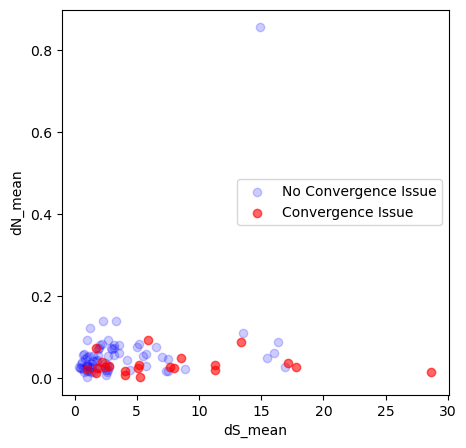

In [57]:
#Visualize dN vs dS with convergence issue flagged

#Plot dN/dS vs mean dS value
fig, ax = plt.subplots(1,1, figsize=(5,5))

#y_values = ['dN_mean', 'dS_mean', 'dN_dS_struct']

#for jj, y_value in enumerate(y_values): 
#ax = axarr[jj]
#xlim = (-0.2,1.2)

y_value =  'dN_mean' #'dN_mean_m0' #'dN_dS_struct_m0' #'dN_mean_m0'#'dN_dS_struct_m0'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dS_mean'# 'Mean(Conservation Rate) [ALL]' # #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_m0_binding_site_found


#dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
#dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = dnds_struct_data[x_value]
y_data = dnds_struct_data[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
#slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
#ax.plot(list(x_data), list(slope*x_data+intercept))
#ax.plot(x_data,x_data)


## Compare M0 between active site and whole protein

In [58]:
#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col = 0 )
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)

dnds_m0_binding_site = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_found.csv'), index_col=0)
m0_binding_site_col_rename = {col : col + '_m0-BS' for col in dnds_m0_binding_site.columns}
dnds_m0_binding_site_for_merge = dnds_m0_binding_site.rename(columns = m0_binding_site_col_rename)

dnds_struct_data = dnds_m0_binding_site_for_merge.merge(dnds_m0_for_merge, how='inner', left_index=True, right_index=True)

In [59]:
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + binding_site_type) + os.sep

with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'rb') as f_in: 
    feature_sizes = pickle.load(f_in)

binding_site_size =[]

for og_ref in dnds_struct_data.index: 
    if og_ref in feature_sizes.keys(): 
        binding_site_size.append(feature_sizes[og_ref])
    else: 
        binding_site_size.append(None)

binding_site_size

dnds_struct_data['BS_size']=binding_site_size

In [60]:
dnds_struct_data.sort_values(by=['dN_dS_struct_m0-BS'], axis = 0, ascending=False)

,og_m0-BS,tree_length_m0-BS,kappa_m0-BS,dN_dS_struct_m0-BS,tree_length_dN_m0-BS,tree_length_dS_m0-BS,convergence_issue_m0-BS,dN_dS_found_m0-BS,dN_mean_m0-BS,dN_std_m0-BS,...,dS>7.5_m0,Mean(Conservation Rate) [ALL]_m0,CV(Type Conservation Rate) [ALL]_m0,Mean(Type Conservation Rate) [ALL]_m0,CV(Conservation Rate) [ALL]_m0,Mean(log2(Abundances)) 10 Sp [EXP]_m0,Median(log2(Abundances)) 10 Sp [EXP]_m0,Std(log2(Abundances)) 10 Sp [EXP]_m0,1k_Mean_log2_Abundances [EXP]_m0,BS_size
OG4360_REF_Scer_AF-P08525-F1-model_v2,OG4360,46.417728,0.83143,0.09879,4.7433,48.0131,False,True,0.121623,0.309072,...,False,0.616483,0.079627,0.762129,0.147848,13.955414,13.955414,NaN,NaN,7
OG1316_REF_Scer_AF-P19097-F1-model_v2,OG1316,42.478963,0.98684,0.09599,4.5681,47.5880,False,True,0.093227,0.090566,...,False,0.675985,0.087202,0.800736,0.149124,16.629100,16.620757,0.953408,11.164836,95
OG1631_REF_Scer_AF-P22217-F1-model_v2,OG1631,33.575196,1.95861,0.08680,2.7629,31.8324,False,True,0.056380,0.082238,...,False,0.617062,0.069133,0.764198,0.125523,18.401145,19.017555,1.500398,10.146729,13
OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,47.369450,1.59336,0.07472,3.3128,44.3357,False,True,0.058118,0.072755,...,False,0.569067,0.090193,0.718584,0.156604,15.714874,15.770421,0.944260,10.150907,28
OG1424_REF_Scer_AF-P00560-F1-model_v2,OG1424,19.541996,1.57591,0.07443,1.5299,20.5552,False,True,0.027824,0.028868,...,False,0.772236,0.061223,0.841865,0.086835,20.544005,20.637585,0.567962,16.223098,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG3978_REF_Scer_AF-P31373-F1-model_v2,OG3978,377.115553,0.32490,0.00164,0.7614,463.5012,True,True,0.018573,0.027331,...,False,0.740914,0.055986,0.840123,0.093612,16.607061,16.662298,0.951322,11.183325,20
OG4398_REF_Scer_AF-Q04178-F1-model_v2,OG4398,426.172073,1.53807,0.00162,0.8997,556.8103,False,True,0.027264,0.031953,...,False,0.734840,0.080321,0.835172,0.123546,14.642519,14.167086,1.295610,NaN,31
OG2357_REF_Scer_AF-P33734-F1-model_v2,OG2357,493.233536,0.61713,0.00150,0.9306,622.0970,True,True,0.026589,0.027560,...,False,0.676215,0.061463,0.783512,0.090921,15.222014,15.281021,0.961742,9.000371,33
OG1786_REF_Scer_AF-P28241-F1-model_v2,OG1786,526.909881,0.33725,0.00053,0.8050,1519.9227,True,True,0.015192,0.028505,...,False,0.732160,0.064702,0.828512,0.098841,16.934232,17.432644,1.622437,8.861301,5


In [61]:
#Add dS>3 filter 

dnds_struct_data['dS>3_m0-BS'] = (dnds_struct_data['dS_mean_m0-BS']>3)

In [62]:
dnds_struct_data.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_and_full.csv'))

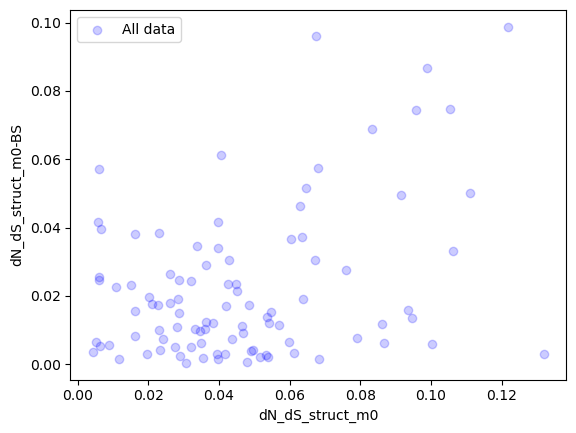

In [63]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' #'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

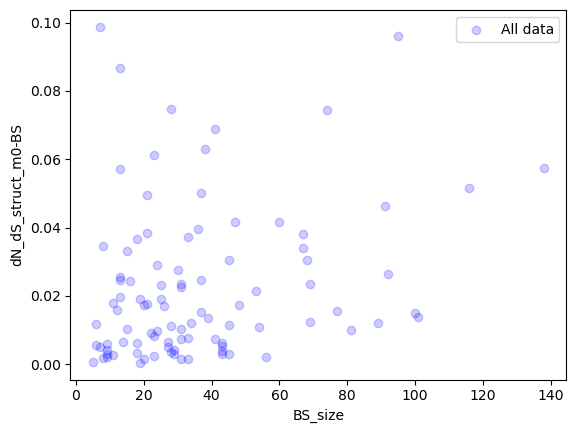

In [64]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'BS_size'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

In [65]:
#Add in Conservation overall and Conservation of Binding Site

#Extract particular binding sites that look interesting



In [66]:
dnds_struct_data.columns

Index(['og_m0-BS', 'tree_length_m0-BS', 'kappa_m0-BS', 'dN_dS_struct_m0-BS',
       'tree_length_dN_m0-BS', 'tree_length_dS_m0-BS',
       'convergence_issue_m0-BS', 'dN_dS_found_m0-BS', 'dN_mean_m0-BS',
       'dN_std_m0-BS', 'dS_mean_m0-BS', 'dS_std_m0-BS', 'og_m0',
       'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0', 'tree_length_dN_m0',
       'tree_length_dS_m0', 'convergence_issue_m0', 'dN_dS_found_m0',
       'dN_mean_m0', 'dN_std_m0', 'dS_mean_m0', 'dS_std_m0', 'dS>3_m0',
       'dS>5_m0', 'dS>7.5_m0', 'Mean(Conservation Rate) [ALL]_m0',
       'CV(Type Conservation Rate) [ALL]_m0',
       'Mean(Type Conservation Rate) [ALL]_m0',
       'CV(Conservation Rate) [ALL]_m0',
       'Mean(log2(Abundances)) 10 Sp [EXP]_m0',
       'Median(log2(Abundances)) 10 Sp [EXP]_m0',
       'Std(log2(Abundances)) 10 Sp [EXP]_m0',
       '1k_Mean_log2_Abundances [EXP]_m0', 'BS_size', 'dS>3_m0-BS'],
      dtype='object')

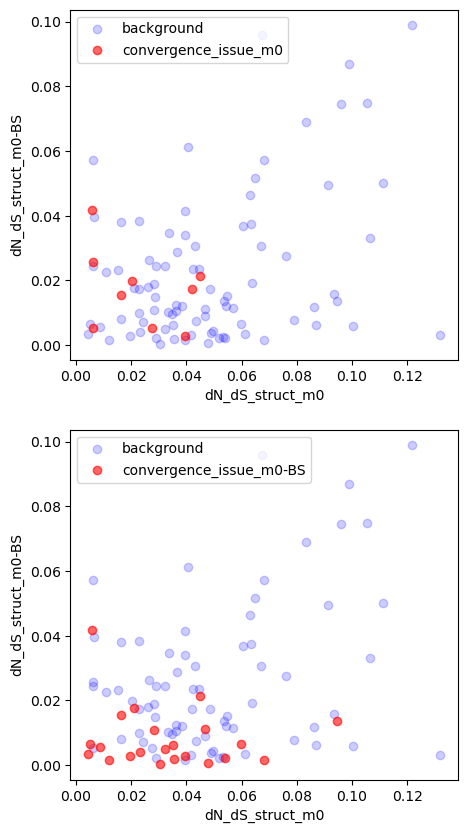

In [67]:
#dN/dS showing convergence issues

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, highlight in enumerate(['convergence_issue_m0', 'convergence_issue_m0-BS']):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data[dnds_struct_data[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data[dnds_struct_data[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [68]:
print('There are ' + str(sum((dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-BS']==False))) + ' ogs which have dN/dS calculated for the binding site and no convergence issues either for the full protein or for the binding site itself')

There are 69 ogs which have dN/dS calculated for the binding site and no convergence issues either for the full protein or for the binding site itself


In [69]:
dnds_struct_data_conv_filt=dnds_struct_data[(dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-BS']==False)]
dnds_struct_data_conv_filt = dnds_struct_data_conv_filt.copy()

In [70]:
#After filtering out convergence issue, filter out dS > 3 for both

dnds_struct_data_conv_filt['dS>3_m0-BS'] = (dnds_struct_data_conv_filt['dS_mean_m0-BS']>3)

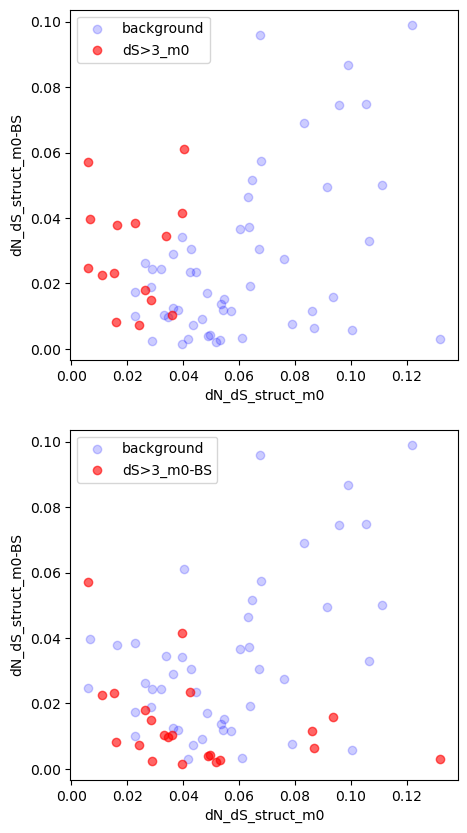

In [71]:
#dN/dS showing dS>3

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_conv_filt

for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [72]:
print('There are ' + str(sum((dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-BS']==False))) + ' orthogroups with binding sites calculated that have dS<3 for both the binding site and for the entire orthogroup')

There are 41 orthogroups with binding sites calculated that have dS<3 for both the binding site and for the entire orthogroup


In [73]:
dnds_struct_data_ds_filt = dnds_struct_data_conv_filt[(dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-BS']==False)]
dnds_struct_data_ds_filt = dnds_struct_data_ds_filt.copy()

Text(0.02, 0.08, 'R=0.61\np=3e-05')

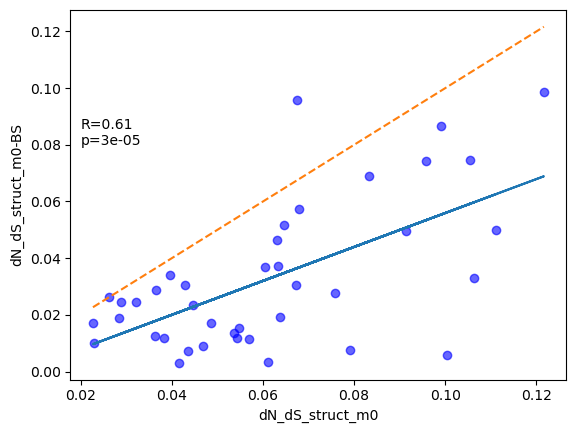

In [79]:
#dN/dS with all filters applied 

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_ds_filt

#for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
#    ax = axarr[jj]
#    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
#    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

#(data_to_plot, color, alpha, label) = dnds_background

(data_to_plot, color, alpha, label) = (dnds_struct_data_in, 'b',0.6,'all data')

#good to quantify r2 here
#for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
#ax.legend()

#add linear regression line to scatterplot for background
x_data = data_to_plot[x_value]
y_data = data_to_plot[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)], '--')
ax.text(0.02, 0.08, 'R={:.2}\np={:.1}'.format(r_value, p_value))

In [78]:
x_data

OG1056_REF_Scer_AF-P21954-F1-model_v2    0.04158
OG5490_REF_Scer_AF-P32340-F1-model_v2    0.06791
OG1388_REF_Scer_AF-P07342-F1-model_v2    0.05368
OG2794_REF_Scer_AF-P00950-F1-model_v2    0.09144
OG1451_REF_Scer_AF-P38998-F1-model_v2    0.05697
OG2197_REF_Scer_AF-P00942-F1-model_v2    0.06716
OG1365_REF_Scer_AF-P29509-F1-model_v2    0.04471
OG3994_REF_Scer_AF-P04397-F1-model_v2    0.03961
OG2677_REF_Scer_AF-P28834-F1-model_v2    0.03646
OG1266_REF_Scer_AF-P23337-F1-model_v2    0.02626
OG1310_REF_Scer_AF-P15202-F1-model_v2    0.05425
OG4312_REF_Scer_AF-P38115-F1-model_v2    0.06338
OG1316_REF_Scer_AF-P19097-F1-model_v2    0.06745
OG2248_REF_Scer_AF-P07143-F1-model_v2    0.04297
OG3575_REF_Scer_AF-P08067-F1-model_v2    0.07590
OG4360_REF_Scer_AF-P08525-F1-model_v2    0.12166
OG1070_REF_Scer_AF-P21524-F1-model_v2    0.03832
OG1979_REF_Scer_AF-P00445-F1-model_v2    0.03215
OG4665_REF_Scer_AF-P32449-F1-model_v2    0.02269
OG3336_REF_Scer_AF-P43567-F1-model_v2    0.06377
OG2453_REF_Scer_AF-P

In [ ]:
#What Binding Sites have a higher DN/DS than expected given dN.  For 5A binding sites, 

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

x_data =  dnds_struct_data_ds_filt[x_value]
y_data =  dnds_struct_data_ds_filt[y_value]

gap = 0.018

columns = ['dN_dS_struct_m0-' + feature,'dN_dS_struct_m0', feature + '_size','Mean(log2(Abundances)) 10 Sp [EXP]_m0', 'sc_uniprot_id', 'sc_gene_id','sc_genename']
dnds_struct_data_ds_filt[y_data>(slope*x_data)+gap].loc[:,columns]

In [81]:
#What Binding Sites have a higher DN/DS.  For uniprot binding sites, just getting threshold

#Columns: 
# Index(['og_m0-BS', 'tree_length_m0-BS', 'kappa_m0-BS', 'dN_dS_struct_m0-BS',
#        'tree_length_dN_m0-BS', 'tree_length_dS_m0-BS',
#        'convergence_issue_m0-BS', 'dN_dS_found_m0-BS', 'dN_mean_m0-BS',
#        'dN_std_m0-BS', 'dS_mean_m0-BS', 'dS_std_m0-BS', 'og_m0',
#        'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0', 'tree_length_dN_m0',
#        'tree_length_dS_m0', 'convergence_issue_m0', 'dN_dS_found_m0',
#        'dN_mean_m0', 'dN_std_m0', 'dS_mean_m0', 'dS_std_m0', 'dS>3_m0',
#        'dS>5_m0', 'dS>7.5_m0', 'Mean(Conservation Rate) [ALL]_m0',
#        'CV(Type Conservation Rate) [ALL]_m0',
#        'Mean(Type Conservation Rate) [ALL]_m0',
#        'CV(Conservation Rate) [ALL]_m0',
#        'Mean(log2(Abundances)) 10 Sp [EXP]_m0',
#        'Median(log2(Abundances)) 10 Sp [EXP]_m0',
#        'Std(log2(Abundances)) 10 Sp [EXP]_m0',
#        '1k_Mean_log2_Abundances [EXP]_m0', 'BS_size', 'dS>3_m0-BS'],

dnds_thresh = 0.05

col_to_view = ['og_m0-BS','dN_dS_struct_m0-BS','dN_mean_m0-BS','dS_mean_m0-BS','Mean(log2(Abundances)) 10 Sp [EXP]_m0', 'dN_dS_struct_m0' ,'dN_mean_m0','dS_mean_m0']

dnds_struct_data_ds_filt.loc[(dnds_struct_data_ds_filt['dN_dS_struct_m0-BS']>dnds_thresh),col_to_view]
#dnds_struct_data_ds_filt.loc[(dnds_struct_data_ds_filt['dN_dS_struct_m0-BS']<0.02)&(dnds_struct_data_ds_filt['dN_dS_struct_m0']>0.09),col_to_view]

,og_m0-BS,dN_dS_struct_m0-BS,dN_mean_m0-BS,dS_mean_m0-BS,Mean(log2(Abundances)) 10 Sp [EXP]_m0,dN_dS_struct_m0,dN_mean_m0,dS_mean_m0
OG1193_REF_Scer_AF-P00924-F1-model_v2,OG1193,0.06298,0.033124,0.525846,19.786384,NaN,NaN,NaN
OG5490_REF_Scer_AF-P32340-F1-model_v2,OG5490,0.05731,0.047452,0.827876,15.698036,0.06791,0.069119,1.017900
OG1316_REF_Scer_AF-P19097-F1-model_v2,OG1316,0.09599,0.093227,0.971178,16.629100,0.06745,0.079761,1.182522
OG4360_REF_Scer_AF-P08525-F1-model_v2,OG4360,0.09879,0.121623,1.231103,13.955414,0.12166,0.088313,0.725944
OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,0.05002,0.023827,0.476283,19.889662,0.11116,0.033918,0.305076
OG1631_REF_Scer_AF-P22217-F1-model_v2,OG1631,0.08680,0.056380,0.649643,18.401145,0.09900,0.093288,0.942310
OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,0.07472,0.058118,0.777825,15.714874,0.10546,0.096661,0.916528
OG1299_REF_Scer_AF-P00549-F1-model_v2,OG1299,0.06901,0.039005,0.565332,18.542742,0.08320,0.048506,0.582965
OG2365_REF_Scer_AF-P08536-F1-model_v2,OG2365,0.05153,0.051247,0.994353,16.483960,0.06469,0.062451,0.965467
OG1424_REF_Scer_AF-P00560-F1-model_v2,OG1424,0.07443,0.027824,0.373733,20.544005,0.09583,0.043922,0.458342


# Look at m0 for Enzymes that have unexpectedly low conservation of Binding site: 

In [25]:
struct_align_cluster_gene_lists_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cluster_gene_lists.json')
with open(struct_align_cluster_gene_lists_fname, 'r') as f:
    struct_align_cluster_gene_lists = json.load(f)
    
#build dictionary from genename to OG_ref

og_ref_lookup_genename = {}

for og_ref, sequence_names in struct_align_cluster_gene_lists.items():
    sc_genes = sequence_names['scer_sequences']['genename']
    for sc_gene in sc_genes: 
        og_ref_lookup_genename[sc_gene] = og_ref
    

In [26]:
low_bsite_cons = {'5A':['QCR6', 'QCR7', 'FAS2', 'SFGH', 'KFA'],    #Filter out RSC6 as it is divided up because of the clustering
            'uniprot': ['PLMT', 'PUT2', 'FAS2', 'GYS1','GYS2','GRE3','YAT2', 'SFGH']
           }

missing_common_names_to_orf = {'SFGH': 'YJL068C', 
                               'GYS1': 'YFR015C', 
                               'GYS2': 'YLR258W', 
                               'KFA': 'YDR428C',  #BNA7
                               'PLMT': 'YJR073C'  #OPI3
                              }
                               
                               

#convert to genename

low_bsite_cons_genename = {}
low_bsite_cons_og_ref = {}
for bsite_cat, common_name_list in low_bsite_cons.items():  
    genename_list = [] 
    og_ref_list = []
    for common_name in common_name_list: 
        if common_name in SC_orfs_lookup.keys(): 
            genename = SC_orfs_lookup[common_name]
        else: 
            genename = missing_common_names_to_orf[common_name]
            print(common_name + ' not in ORF Lookup')
        genename_list.append(genename)
        og_ref_list.append(og_ref_lookup_genename[genename]) 
    
    low_bsite_cons_genename[bsite_cat] = genename_list
    low_bsite_cons_og_ref[bsite_cat] = og_ref_list

#These share SFGH FAS2
#Find 

NameError: name 'SC_orfs_lookup' is not defined

In [145]:
dnds_struct_data = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_and_full.csv'), index_col = 0)

In [146]:
set(dnds_struct_data.index) & set(low_bsite_cons_og_ref['uniprot'])

{'OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'OG4391_REF_Scer_AF-P40017-F1-model_v2'}

In [147]:
low_bsite_cons_og_ref['uniprot']

['OG2645_REF_Scer_AF-P05375-F1-model_v2',
 'OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'OG1316_REF_Scer_AF-P19097-F1-model_v2',
 'OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'OG4391_REF_Scer_AF-P40017-F1-model_v2',
 'OG3241_REF_Scer_AF-P40363-F1-model_v2']

In [176]:
goi = 'OG2645_REF_Scer_AF-P05375-F1-model_v2'
struct_align_cluster_gene_lists[goi]

{'all_sequences': ['Calb_AF-A0A1D8PKM5-F1-model_v2',
  'REF_Scer_AF-P05375-F1-model_v2',
  'Spom_AF-O74827-F1-model_v2',
  'alloascoidea_hylecoeti__OG2645__0_4987',
  'ascoidea_rubescens__OG2645__6_4396',
  'candida_apicola__OG2645__13_663',
  'candida_tropicalis__OG2645__30_5327',
  'cyberlindnera_jadinii__OG2645__35_4400',
  'debaryomyces_hansenii__OG2645__36_4456',
  'eremothecium_gossypii__OG2645__40_1907',
  'geotrichum_candidum__OG2645__43_5016',
  'kazachstania_naganishii__OG2645__49_969',
  'kluyveromyces_lactis__OG2645__50_1107',
  'kluyveromyces_marxianus__OG2645__51_3365',
  'komagataella_pastoris__OG2645__52_2659',
  'lachancea_thermotolerans__OG2645__64_3112',
  'lipomyces_starkeyi__OG2645__66_726',
  'ogataea_parapolymorpha__OG2645__104_2289',
  'pachysolen_tannophilus__OG2645__106_3128',
  'tortispora_caseinolytica__OG2645__134_4012',
  'torulaspora_delbrueckii__OG2645__135_1927',
  'vanderwaltozyma_polyspora__OG2645__136_4985',
  'wickerhamomyces_anomalus__OG2645__139_9

In [177]:
feature_sizes[goi]

3

In [170]:
dnds_struct_data.loc[goi]

KeyError: 'OG1022_REF_Scer_AF-P38715-F1-model_v2'

In [63]:
[uniprot_common_name + ': ' + og_ref_lookup_genename[missing_common_names_to_orf[uniprot_common_name]]  for uniprot_common_name in ['PLMT', 'GYS1', 'GYS2']]
#og_ref_lookup_genename[missing_common_names_to_orf['KFA']]  og_ref_lookup_genename[SC_orfs_lookup[gene]]

['PLMT: OG2645_REF_Scer_AF-P05375-F1-model_v2',
 'GYS1: OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'GYS2: OG1266_REF_Scer_AF-P23337-F1-model_v2']

In [64]:
[sc_common_name + ': ' + og_ref_lookup_genename[SC_orfs_lookup[sc_common_name]]  for sc_common_name in ['PUT2','GRE3','YAT2']]

['PUT2: OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'GRE3: OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'YAT2: OG4391_REF_Scer_AF-P40017-F1-model_v2']

Results: 

5A: 

RSC - wierd alignment

Fas2 looks like a normal group - the others have been filtered out. 

DN/dS 0.06745
DN/dS binding site: 0.09599

'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2'  
The thing designated as binding site is very gappy and fails my trimming filter - strict trimming makes it smaller than 0.25 of the average sequence length.  Looks like the binding site is really only there in S. cer.  
'QCR7', 'OG3208_REF_Scer_AF-P00128-F1-model_v2'  Size 3 - filtered out
'SFGH', 'OG3241_REF_Scer_AF-P40363-F1-model_v2'  Size 4 - filtered out 
'KFA', 'OG4463_REF_Scer_AF-Q04066-F1-model_v2'   very high dS


Uniprot: 

FAS2
GYS1: OG1266_REF_Scer_AF-P23337-F1-model_v2,
GYS2: OG1266_REF_Scer_AF-P23337-F1-model_v2

 
Filtered out: 
'SFGH' as above 


'PLMT: OG2645_REF_Scer_AF-P05375-F1-model_v2',
'PUT2: OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'GRE3: OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'YAT2: OG4391_REF_Scer_AF-P40017-F1-model_v2']



In [ ]:
OG4352_REF_Scer_AF-P00127-F1-model_v2 OG3208_REF_Scer_AF-P00128-F1-model_v2 OG3241_REF_Scer_AF-P40363-F1-model_v2 OG4463_REF_Scer_AF-Q04066-F1-model_v2

#Try to run binding site M0 calculation for these four

#If any succeed, try to run it for all


In [ ]:
QCR6

>Calb_AF-A0A1D8PJT8-F1-model_v2.pdb
---------V----T--
>REF_Scer_AF-P00127-F1-model_v2.pdb
EE-LK-TV--VV-A-NE
>Spom_AF-O42932-F1-model_v2.pdb
KF------T----A-SL
>alloascoidea_hylecoeti__OG4352__0_4899.pdb
-V---------------
>ascoidea_rubescens__OG4352__6_2774.pdb
----K------------
>candida_tropicalis__OG4352__30_4463.pdb
-----------------
>cyberlindnera_jadinii__OG4352__35_207.pdb
---YT-LK---------
>debaryomyces_hansenii__OG4352__36_96.pdb
-----------------
>geotrichum_candidum__OG4352__43_1164.pdb
--WTD-VE---------
>komagataella_pastoris__OG4352__52_2977.pdb
-Y--T------------
>lipomyces_starkeyi__OG4352__66_2394.pdb
----I-------E----
>ogataea_parapolymorpha__OG4352__104_3664.pdb
-F--D-----IT-Y---
>pachysolen_tannophilus__OG4352__106_5701.pdb
-----------S-----
>tortispora_caseinolytica__OG4352__134_1986.pdb
-----I-----------
>torulaspora_delbrueckii__OG4352__135_1899.pdb
-----------S-----
>wickerhamomyces_anomalus__OG4352__139_5006.pdb
----A------------
>yHMPu5000034604_sporopachydermia_lactativora_160519__OG4352__170_4168.pdb
-S-LL-TV---------
>yarrowia_lipolytica__OG4352__144_3930.pdb
-----------------
>zygosaccharomyces_rouxii__OG4352__342_4105.pdb
-----------E-----


## Features;  Surface and Core



In [ ]:
# Surface / Core: 
# Note that these are only calculated for residues in Olivers alignments that means they are not calculated for residues in 
# a sequence that do not align with the reference sequence. 


#feature='surface'  #core
min_feature_size = 5
#feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

sasa_cut = 0.25

dict_sasa_max = {'ALA': 1.2831596, 'CYS': 1.6075546, 'ASP': 1.6942018, 'GLU': 1.9520556, 'PHE': 2.3931725, 
                     'GLY': 0.9859995, 'HIS': 2.1476686, 'ILE': 1.9781175, 'LYS': 2.4149895, 'LEU': 1.9980704, 
                     'MET': 2.1391654, 'ASN': 1.8180864, 'PRO': 1.6501249, 'GLN': 1.996297, 'ARG': 2.7603362, 
                     'SER': 1.4527341, 'THR': 1.6533911, 'VAL': 1.7248302, 'TRP': 2.773364, 'TYR': 2.5169885,
                     'XYZ': 1.}

surface_core_abbrev = {'core':'C',
                      'surface':'S'
                      }

#Threshold for a column of an alignment to call it "core" (above 0.80 core), "surface" (below 0.2 core) or "unclear"
surface_core_pct_thresholds = (0.2, 0.8) # Should test sensitivity to this parameter. 


In [16]:
# Trim Alignment by Structural Feature

#  Note:  Need to make fasta_renamed and cds_align folders before running this
#  This routine makes alignments (stored in feature_subsets/<feature>/fasta_renamed) and cds alignments (stored in feature_subsets/<feature>/cds_aln) for just the specified feature

#Example OG1316_REF_Scer_AF-P19097-F1-model_v2 -- FAS2 as it is an enzyme with a less conserved binding site
#og_ref = 'OG1316_REF_Scer_AF-P19097-F1-model_v2'

feature_sizes = {'surface':{},
                 'core': {}
                }

surface_core_data = {}

log = ''

for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    #og_ref = 'OG1030_REF_Scer_AF-P37291-F1-model_v2'
    #og_ref = 'OG1694_REF_Scer_AF-P39713-F1-model_v2'
    og_ref = fasta_file.split('.')[0]
    print(og_ref)

    ref = '_'.join(og_ref.split('_')[1:])


    #Could add much more to og_surface_core_data and save that


    if ref+'.pkl' in os.listdir(summary_data_dir): 
        #Load Summary data for given og_ref
        og_summary_fname = summary_data_dir + os.sep + ref + '.pkl'
        with open(og_summary_fname, 'rb') as f_in:
                og_summary = pickle.load(f_in)

        #Identify Core and Surface Residues for the orthogroup.  
        og_surface_core_data, log_ref = dyt.extract_surface_core(og_summary, sasa_cut, dict_sasa_max)
        
        if len(log_ref)>1:
            log = log + og_ref + '\n' + log_ref + '\n'

        #For untrimmed alignment extract percentage core/surface for each column in the alignment
        # Load Untrimmed Alignment
        aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
        aln = AlignIO.read(open(aln_fname),'fasta')

        core_column_pct_untrimmed, column_occupancy_untrimmed, surface_core_aligned_mat_untrimmed, record_order_untrimmed = dyt.surface_core_analysis_alignment(aln, og_surface_core_data)

        #For each trimmed alignment extract percentage core/surface for each column in the alignment.  
        aln_trim_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trim_strict/' + og_ref + '.tm.fasta.clipkit')

        core_column_pct, column_occupancy, surface_core_aligned_mat, record_order = dyt.surface_core_analysis_untrimmed_to_trimmed(aln_trim_fname,surface_core_aligned_mat_untrimmed)

        #Extract a protein and codon alignment for core and surface
        aln_trimmed = AlignIO.read(open(aln_trim_fname),'fasta')
        aln_trimmed_len = aln_trimmed.get_alignment_length()

        aln_cds_fname_short = og_ref + '.tm.fasta.clipkit.cds'
        if aln_cds_fname_short in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_trim_strict/')):
                                                
            aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_trim_strict/' + aln_cds_fname_short)
            
            aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')

            og_surface_core_data['trimmed_alignment'] = {}

            #Based on trimmed alignment threshold choose Core / Surface part of protein

            surface_core_discrete = []
            for col_core_pct in core_column_pct:
                if col_core_pct<surface_core_pct_thresholds[0]:
                    surface_core_discrete.append('S')
                elif col_core_pct>surface_core_pct_thresholds[1]:
                    surface_core_discrete.append('C')
                else: 
                    surface_core_discrete.append('N')

            #Quantify amount of core, surface and neither
            og_surface_core_count = Counter(surface_core_discrete)

            og_surface_core_data['trimmed_alignment']['pct_core'] = og_surface_core_count['C']/aln_trimmed_len
            og_surface_core_data['trimmed_alignment']['pct_surface'] = og_surface_core_count['S']/aln_trimmed_len
            og_surface_core_data['trimmed_alignment']['pct_unclear'] = og_surface_core_count['N']/aln_trimmed_len


            #Could also compare this to Oliver's based only on the ref. 

            #Extract a protein and codon alignment for core and surface and save

            #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
            #Converts alignment to numpy array then converts back to aln object

            for feature in ['surface','core']: 
                feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

                feature_inds = [jj for jj,col_status in enumerate(surface_core_discrete) if col_status==surface_core_abbrev[feature]]

                aln_temp = aln_trimmed[:,0:0]
                aln_cds_temp = aln_cds[:,0:0]

                for x in feature_inds:
                    aln_subset = aln_temp[:,:] + aln_trimmed[:, (x-1):x]
                    aln_temp = aln_subset

                    aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                    aln_cds_temp = aln_cds_subset

                #Save alignment subset
                aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                with open(aln_subset_fname_out,'w') as f_out: 
                    for record in aln_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')

                aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                with open(aln_cds_subset_fname_out,'w') as f_out: 
                    for record in aln_cds_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')

                feature_sizes[feature][og_ref] = aln_subset.get_alignment_length()

            surface_core_data[og_ref] = og_surface_core_data
        else: 
            message = og_ref + ' does not have trimmed codon alignment.  May not have minimum structure/sequence filter'
            print(message)
            log = log + message + '\n'

log_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/core_surface_subalignment_log.log')

with open(log_fname,'w') as f_out:
    f_out.write(log)

surface_core_data_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/surface_core_data.json')
with open(surface_core_data_fname, 'w') as f:
    json.dump(surface_core_data, f, sort_keys=True, indent=4 )

surface_core_sizes_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/surface_core_sizes.json')
with open(surface_core_sizes_fname, 'w') as f:
    json.dump(feature_sizes, f, sort_keys=True, indent=4 )

OG1022_REF_Scer_AF-P49954-F1-model_v2
OG1056_REF_Scer_AF-P21954-F1-model_v2
OG1055_REF_Scer_AF-P52910-F1-model_v2
OG1103_REF_Scer_AF-P47771-F1-model_v2
OG1039_REF_Scer_AF-P19414-F1-model_v2
OG1016_REF_Scer_AF-P00330-F1-model_v2
OG1087_REF_Scer_AF-P39518-F1-model_v2
OG1032_REF_Scer_AF-P03965-F1-model_v2
OG1030_REF_Scer_AF-P37291-F1-model_v2
alignment column has no surface or core residues - may be empty
OG1022_REF_Scer_AF-P38715-F1-model_v2
OG1004_REF_Scer_AF-P40459-F1-model_v2
OG1052_REF_Scer_AF-P07245-F1-model_v2
alignment column has no surface or core residues - may be empty
OG1021_REF_Scer_AF-P40047-F1-model_v2
OG1168_geotrichum_candidum__OG1168__43_5899
OG1157_REF_Scer_AF-P17649-F1-model_v2
OG1145_REF_Scer_AF-P00358-F1-model_v2
OG1210_REF_Scer_AF-P38891-F1-model_v2
OG1193_REF_Scer_AF-P00924-F1-model_v2
OG1126_REF_Scer_AF-P38067-F1-model_v2
OG1121_REF_Scer_AF-P53045-F1-model_v2
OG1111_REF_Scer_AF-P49367-F1-model_v2
OG1170_REF_Scer_AF-P21826-F1-model_v2
OG1180_REF_Scer_AF-P41903-F1-m

{'OG4118_REF_Scer_AF-P07255-F1-model_v2': 1,
 'OG4346_REF_Scer_AF-P10174-F1-model_v2': 5,
 'OG4360_REF_Scer_AF-P08525-F1-model_v2': 3,
 'OG4552_REF_Scer_AF-P37299-F1-model_v2': 5,
 'OG4555_REF_Scer_AF-P32799-F1-model_v2': 3,
 'OG4751_REF_Scer_AF-P04039-F1-model_v2': 1,
 'OG4744_REF_Scer_AF-P22289-F1-model_v2': 2}

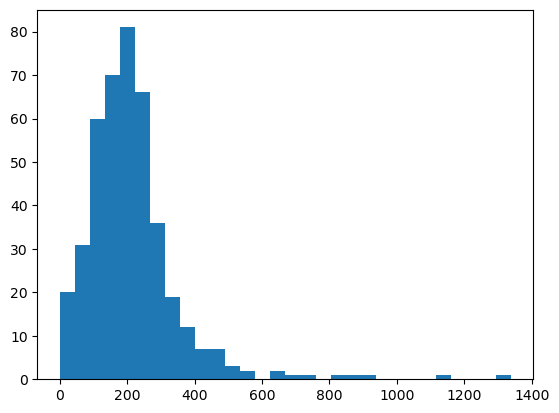

In [34]:
feature = 'core'
plt.hist(feature_sizes[feature].values(),bins=30)

small_features = {}

for og_ref, feature_size in feature_sizes[feature].items():
    if feature_size <= 5: 
        small_features[og_ref] = feature_size
    
small_features


wickerhamomyces_anomalus__OG1694__139_1189 is a short protein (60 residues) and only has surfaces.  

It looks like some error from Sandra's calculations. 

It is present in Oliver's summary data, but not in the TM align alignments. Nir must have filtered it out.

I only analyze the TM align alignments except for ful protein count and 

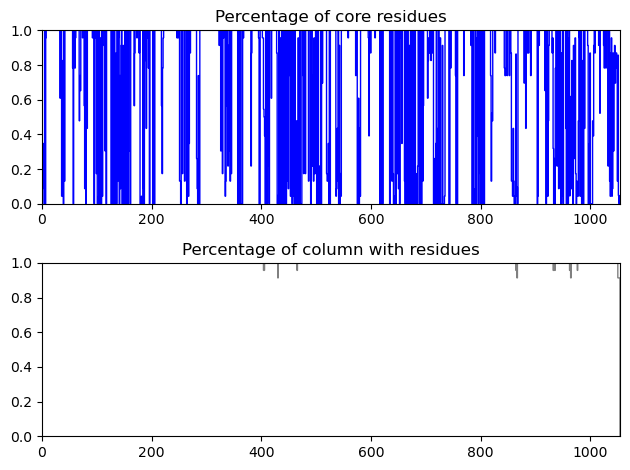

In [246]:
#Example analysis of core column percentage and column occupancy for untrimmed alignment. 

fig, axarr = plt.subplots(2,1)
ind_range = (0,len(core_column_pct))#(1000,1100)#(0,120)
ylim = (0,1)
xlim = (0,len(core_column_pct))

ax0 = axarr[0]
ax0.stairs(core_column_pct[ind_range[0]:ind_range[1]], color='blue')
ax0.set_ylim(ylim)
ax0.set_xlim(xlim)
ax0.set_title("Percentage of core residues")

ax1 = axarr[1]
ax1.stairs(column_occupancy[ind_range[0]:ind_range[1]], color='grey')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title("Percentage of column with residues")

fig.tight_layout()


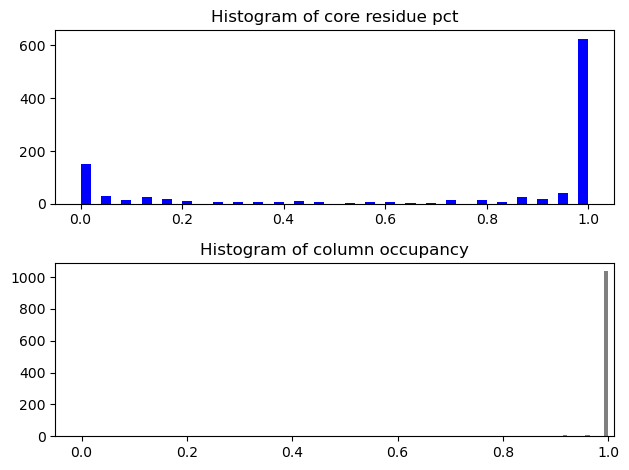

In [247]:
fig, axarr = plt.subplots(2,1)

ax0 = axarr[0]
ax0.hist(core_column_pct, color='blue', bins=50)
#ax0.set_ylim(ylim)
#ax0.set_xlim(xlim)
ax0.set_title("Histogram of core residue pct")

ax1 = axarr[1]
ax1.hist(column_occupancy, color='grey')
#ax1.set_ylim(ylim)
ax1.set_xlim((-0.05,1.01))
ax1.set_title("Histogram of column occupancy")

fig.tight_layout()

Text(0, 0.5, 'Column occupancy')

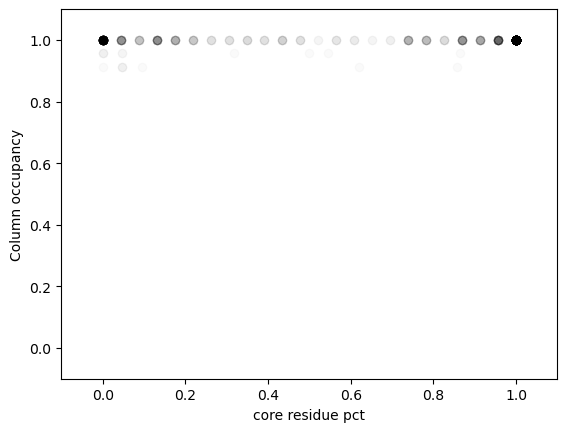

In [248]:
fig, ax = plt.subplots(1,1)

ax.scatter(core_column_pct, column_occupancy, color='black', alpha=0.02)
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-0.1,1.1)
#ax0.set_xlim(xlim)
ax.set_xlabel("core residue pct")
ax.set_ylabel("Column occupancy")

#fig.tight_layout()

In [ ]:
    
    
#         #Check to see if the feature exists for that protein
#         if 'Binding Site' in set(og_summary['Mapping Colors'].keys()):

#             aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
#             aln = AlignIO.read(open(aln_fname),'fasta')

#             aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
#             aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')


#             #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates

#             ref_ind=None
#             for (jj, record) in enumerate(aln): 
#                 if ref == record.id.split('.')[0]:
#                     ref_ind = jj

#             #Get map for reference sequence from msa index
#             ref_seq_from_msa = str(aln[ref_ind,:].seq)
#             ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)


#             #Get list of indices for the feature   
#             feat_inds_ref = []
#             for jj, feature_present in enumerate((og_summary['Mapping Colors']['Binding Site']==1)): 
#                 if feature_present:
#                     feat_inds_ref.append(jj)

#             feature_size = len(feat_inds_ref)
#             feature_sizes[og_ref] = feature_size

#             if feature_size>= min_feature_size: 
#                 feat_inds_msa = []


#                 for feat_ind in feat_inds_ref: 
#                     feat_inds_msa.append(ref2msa[feat_ind])

#                     #Verify seq_squeeze is mapping correctly
#                     assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"

#                     #Verify identical sequence in tm_align reference and in Output/Summary data
#                     aa_3L_caps = og_summary['Mapping']['Amino Acid'][0,:][feat_ind]
#                     aa_3L = aa_3L_caps[0] + aa_3L_caps[1:].lower()
#                     trans_dict[aa_3L]
#                     assert (ref_seq[feat_ind] == trans_dict[aa_3L]), "Difference in sequence between tm_align alignment and Output/Summary data: " + og_ref + ' ' + str(feat_ind) + ' ' + ref_seq[feat_ind] + ' vs ' + aa3L 

#                 #Extract Alignment Subsets
#                 #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
#                 #Converts alignment to numpy array then converts back to aln object

#                 aln_temp = aln[:,0:0]
#                 aln_cds_temp = aln_cds[:,0:0]

#                 for x in feat_inds_msa:
#                     aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
#                     aln_temp = aln_subset

#                     aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
#                     aln_cds_temp = aln_cds_subset

#                 #Save alignment subset
#                 aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
#                 with open(aln_subset_fname_out,'w') as f_out: 
#                     for record in aln_subset:
#                         f_out.write('>' + record.id + '\n')   # Could add a length to this
#                         f_out.write(str(record.seq) + '\n')

#                 aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
#                 with open(aln_cds_subset_fname_out,'w') as f_out: 
#                     for record in aln_cds_subset:
#                         f_out.write('>' + record.id + '\n')   # Could add a length to this
#                         f_out.write(str(record.seq) + '\n')
#             else: 
#                 print(feature + ' size of ' + str(feature_size) + ' below threshold size of ' + str(min_feature_size))

#         else: 
#             print('No ' + feature + ' for ' + og_ref)
    
#     else: 
#         print('No .pkl file for ' + og_ref)

In [ ]:
# #Protein sequence: 
# og_prot_unaligned_fname = os.path.normpath(base_dir + '/selected_proteins/og_sequences/proteome_tm/' + og_ref + '.pep.fasta')

# og_prot_unaligned = {}
# for record in SeqIO.parse(og_prot_unaligned_fname, "fasta"):
#         og_prot_unaligned[record.id] = record.seq

# #From Reference Based Alignment


In [7]:
#og_inner_outer_data['vanderwaltozyma_polyspora__OG1316__136_1009']['full_protein_assignment']

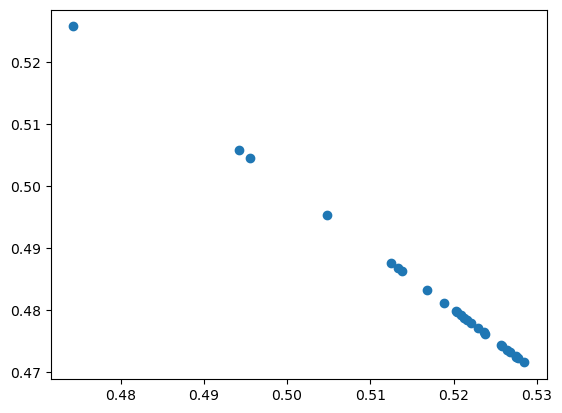

In [18]:
#Plot percentage inner and outer for a given OG.  Calculate averages and std. 

fig, ax = plt.subplots(1,1)

inners = []
outers = []

for key, data in og_inner_outer_data.items(): 
    #print(key)
    inners.append(data['full_protein_pct']['inner'])
    outers.append(data['full_protein_pct']['outer'])
    
ax.scatter(inners, outers)

np.std(inners)


In [10]:
# b#Older version going from Olivers

# #For a given protein lists how many are Inner, Outer, Missing From Alignment, Not assigned 
# #Would be good to check Oliver's alignment vs my alignment to make sure it is correct.  
# #This should be something saved somewhere as a reference


# og_inner_outer_data = {}



# #Protein sequence: 
# og_prot_unaligned_fname = os.path.normpath(base_dir + '/selected_proteins/og_sequences/proteome_tm/' + og_ref + '.pep.fasta')

# og_prot_unaligned = {}
# for record in SeqIO.parse(og_prot_unaligned_fname, "fasta"):
#         og_prot_unaligned[record.id] = record.seq

# #From Reference Based Alignment


# for prot_ind, prot_name in enumerate(og_summary['Molecules'].keys()): 
#     #prot_name = 'yHMPu5000034957_hanseniaspora_osmophila_160519__OG1316__247_2096'
#     #prot_ind = prot_ind_lookup[prot_name]
#     mapping_ref_based_aln = og_summary['Mapping']['Mapping'][prot_ind]

#     prot_seq = og_prot_unaligned[prot_name + '.pdb']

#     #Initialize inner_outer, a vector that indicates whether a residue in the sequence is, core, surface, or NA if not calculated 
#     inner_outer = ['NA']*len(prot_seq)

#     #outer_residues: 
#     for jj, outer_bool in enumerate(outer_res[prot_ind]): 
#         if outer_bool: 
#             seq_ind = mapping_ref_based_aln[jj]
#             inner_outer[seq_ind]= 'outer'

#     #inner_residues: 
#     for jj, inner_bool in enumerate(inner_res[prot_ind]): 
#         if inner_bool: 
#             seq_ind = mapping_ref_based_aln[jj]
#             inner_outer[seq_ind]= 'inner'

#     inner_outer_count = Counter(inner_outer)

#     #Check that all residues for the protein in the ref_based alignment are assigned to either core or surface. 
#     assert len([item for item in mapping_ref_based_aln if item != -1])== (inner_outer_count['outer'] + inner_outer_count['inner']), 'Residue aligned to reference structure not assigned as inner or outer'

#     inner_outer_pct = {}
#     for key, count in inner_outer_count.items():
#         inner_outer_pct[key] = count/len(prot_seq)

#     og_inner_outer_data[prot_name] = {'full_protein_assignment' : inner_outer,
#                                       'full_protein_count': dict(inner_outer_count), 
#                                       'full_protein_pct' : inner_outer_pct,
#                                       'ref_alignment_index' : prot_ind
#                                      }


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Import DN/DS value from surface and core for analysis

In [232]:
feature = 'core'
#'surface','core', 'uniprot_binding_site', 'binding_site' # Oliver's 5A definition

In [233]:
#Only need to do this once to load data
#feature = 'surface'  #'core'    #Also 'binding_site' and 'uniprot_binding_site' should work

m0_base = base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature) + os.sep

dnds_m0_feature, branch_tables = dyt.load_m0_data(m0_base, branch_table_out=True)

dnds_m0_feature.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature +'/m0_' + feature + '.csv'))

convergence issue in OG4008_REF_Scer_AF-Q12676-F1-model_v2
convergence issue in OG1180_REF_Scer_AF-P41903-F1-model_v2
convergence issue in OG3000_REF_Scer_AF-P40350-F1-model_v2
convergence issue in OG1030_REF_Scer_AF-P37291-F1-model_v2
convergence issue in OG3114_REF_Scer_AF-P35202-F1-model_v2
convergence issue in OG3767_REF_Scer_AF-P39683-F1-model_v2
convergence issue in OG2397_REF_Scer_AF-P32796-F1-model_v2
convergence issue in OG3877_REF_Scer_AF-P05374-F1-model_v2
convergence issue in OG1273_REF_Scer_AF-P40012-F1-model_v2
convergence issue in OG3801_REF_Scer_AF-Q12455-F1-model_v2
convergence issue in OG3445_REF_Scer_AF-P08432-F1-model_v2
convergence issue in OG3241_REF_Scer_AF-P40363-F1-model_v2
convergence issue in OG3069_REF_Scer_AF-P49017-F1-model_v2
convergence issue in OG1564_REF_Scer_AF-P08019-F1-model_v2
convergence issue in OG1471_REF_Scer_AF-P33333-F1-model_v2
convergence issue in OG1585_REF_Scer_AF-P20967-F1-model_v2
convergence issue in OG3416_REF_Scer_AF-P40099-F1-model_

In [235]:
#Load and process compiled data
dnds_m0_feature = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature + '/m0_' + feature + '.csv'), index_col=0)


#Load size data
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

surface_core_sizes_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/surface_core_sizes.json')
with open(surface_core_sizes_fname, 'r') as f:
    feature_sizes = json.load(f)

small_features = {}

for og_ref, feature_size in feature_sizes[feature].items():
    if feature_size <= 5: 
        small_features[og_ref] = feature_size

print('small_features')
print(small_features)

feature_size =[]

feature_sizes_feature = feature_sizes[feature]

for og_ref in dnds_m0_feature.index: 
    if og_ref in feature_sizes_feature.keys(): 
        feature_size.append(feature_sizes_feature[og_ref])
    else: 
        feature_size.append(None)

dnds_m0_feature[feature + '_size']=feature_size


#Filter out Features below size threshold
size_thresh = 5

dnds_m0_feature_size_filt = dnds_m0_feature[dnds_m0_feature[feature+'_size']>size_thresh]


print(str(sum(dnds_m0_feature_size_filt['dN_dS_found'])) + ' orthogroups where ' + feature + ' was larger than ' + str(size_thresh) + ' and dN/dS was calculated for ' + feature)

dnds_m0_feature_found = dnds_m0_feature_size_filt[dnds_m0_feature_size_filt['dN_dS_found']==True]

print(str(sum(dnds_m0_feature_found['convergence_issue']==True)) + ' of those had a convergence issue')


dnds_m0_feature_found.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature + '/m0_' + feature + '_found.csv'))

small_features
{'OG4118_REF_Scer_AF-P07255-F1-model_v2': 1, 'OG4346_REF_Scer_AF-P10174-F1-model_v2': 5, 'OG4360_REF_Scer_AF-P08525-F1-model_v2': 3, 'OG4552_REF_Scer_AF-P37299-F1-model_v2': 5, 'OG4555_REF_Scer_AF-P32799-F1-model_v2': 3, 'OG4744_REF_Scer_AF-P22289-F1-model_v2': 2, 'OG4751_REF_Scer_AF-P04039-F1-model_v2': 1}
416 orthogroups where core was larger than 5 and dN/dS was calculated for core
72 of those had a convergence issue


In [227]:
dnds_m0_feature_found.columns

Index(['og', 'tree_length', 'kappa', 'dN_dS_struct', 'tree_length_dN',
       'tree_length_dS', 'convergence_issue', 'dN_dS_found', 'dN_mean',
       'dN_std', 'dS_mean', 'dS_std', 'core_size'],
      dtype='object')

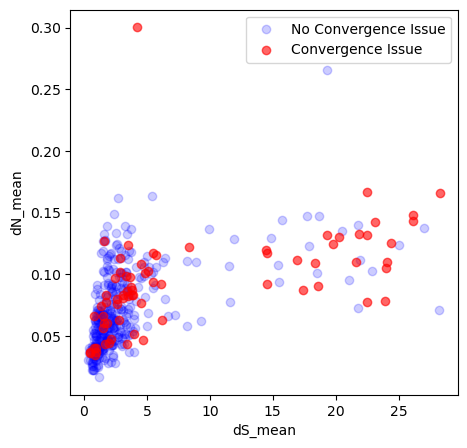

In [237]:
#Visualize dN vs dS with convergence issue flagged

#Plot dN/dS vs mean dS value
fig, ax = plt.subplots(1,1, figsize=(5,5))

#y_values = ['dN_mean', 'dS_mean', 'dN_dS_struct']

#for jj, y_value in enumerate(y_values): 
#ax = axarr[jj]
#xlim = (-0.2,1.2)

y_value =  'dN_mean' #'dN_mean_m0' #'dN_dS_struct_m0' #'dN_mean_m0'#'dN_dS_struct_m0'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dS_mean'# 'Mean(Conservation Rate) [ALL]' # #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_m0_feature_found


#dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
#dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = dnds_struct_data[x_value]
y_data = dnds_struct_data[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
#slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
#ax.plot(list(x_data), list(slope*x_data+intercept))
#ax.plot(x_data,x_data)


## Compare M0 between feature and whole protein

In [238]:
#Load M0 Data
#feature = 'surface' #'core' #'surface'
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col = 0 )
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)

dnds_m0_feature = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature + '/m0_' + feature + '_found.csv'), index_col=0)
m0_feature_col_rename = {col : col + '_m0-'+feature for col in dnds_m0_feature.columns}
dnds_m0_feature_for_merge = dnds_m0_feature.rename(columns = m0_feature_col_rename)

dnds_struct_data = dnds_m0_feature_for_merge.merge(dnds_m0_for_merge, how='inner', left_index=True, right_index=True)

#map on ids
SC_orfs_lookup, SC_genename_lookup, SC_features_lookup = dyt.read_SGD_features()
sc_uniprot_map = dyt.load_model_swissprot_id_2_gene_id()['Scer']

In [239]:
og_ref = dnds_struct_data.index[0]

uniprot_ids = []
sc_gene_ids = []
sc_genenames = []

for og_ref in dnds_struct_data.index:
    uniprot_id = og_ref.split('_')[3].split('-')[1]
    uniprot_ids.append(uniprot_id)
    sc_gene_id = sc_uniprot_map[uniprot_id]
    sc_gene_ids.append(sc_gene_id)
    sc_genename = SC_genename_lookup[sc_gene_id]
    sc_genenames.append(sc_genename)

dnds_struct_data['sc_uniprot_id'] = uniprot_ids
dnds_struct_data['sc_gene_id'] = sc_gene_ids
dnds_struct_data['sc_genename'] = sc_genenames

In [240]:
dnds_struct_data

,og_m0-core,tree_length_m0-core,kappa_m0-core,dN_dS_struct_m0-core,tree_length_dN_m0-core,tree_length_dS_m0-core,convergence_issue_m0-core,dN_dS_found_m0-core,dN_mean_m0-core,dN_std_m0-core,...,CV(Type Conservation Rate) [ALL]_m0,Mean(Type Conservation Rate) [ALL]_m0,CV(Conservation Rate) [ALL]_m0,Mean(log2(Abundances)) 10 Sp [EXP]_m0,Median(log2(Abundances)) 10 Sp [EXP]_m0,Std(log2(Abundances)) 10 Sp [EXP]_m0,1k_Mean_log2_Abundances [EXP]_m0,sc_uniprot_id,sc_gene_id,sc_genename
OG2746_REF_Scer_AF-P40495-F1-model_v2,OG2746,123.476660,1.12065,0.01372,2.1243,154.8050,False,True,0.041655,0.041841,...,0.054123,0.838281,0.078490,18.091476,17.835064,0.892610,10.904825,P40495,YIL094C,LYS12
OG1857_REF_Scer_AF-P38795-F1-model_v2,OG1857,69.968254,1.14265,0.01933,1.8706,96.7568,False,True,0.038169,0.034386,...,0.048895,0.857296,0.085285,13.253228,12.869952,1.229278,6.618772,P38795,YHR074W,QNS1
OG1111_REF_Scer_AF-P49367-F1-model_v2,OG1111,81.706763,1.11011,0.01926,2.0821,108.0990,False,True,0.042494,0.040600,...,0.033362,0.804965,0.052071,13.622462,13.568882,0.989395,8.015806,P49367,YDR234W,LYS4
OG5441_REF_Scer_AF-P00724-F1-model_v2,OG5441,35.115296,1.32188,0.08608,3.3944,39.4320,False,True,0.117045,0.082589,...,0.074381,0.679916,0.104705,14.778412,14.746981,1.179589,NaN,P00724,YIL162W,SUC2
OG1322_REF_Scer_AF-P38009-F1-model_v2,OG1322,45.483103,1.27056,0.03029,1.6697,55.1165,False,True,0.029296,0.032780,...,0.033972,0.897331,0.051416,17.165326,17.231636,1.093929,11.593045,P38009,YMR120C,ADE17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG1516_REF_Scer_AF-P10659-F1-model_v2,OG1516,28.494366,1.58009,0.03540,1.1921,33.6714,False,True,0.022491,0.025241,...,0.044753,0.884346,0.064658,18.236442,18.141450,0.522294,10.342092,P10659,YLR180W,SAM1
OG1096_REF_Scer_AF-P48570-F1-model_v2,OG1096,65.158417,1.13080,0.01394,1.3034,93.5310,False,True,0.016496,0.025421,...,0.025037,0.939318,0.047674,16.323637,16.738810,1.207879,9.871280,P48570,YDL182W,LYS20
OG1491_REF_Scer_AF-P40506-F1-model_v2,OG1491,204.875427,1.15919,0.01156,3.0751,266.1094,False,True,0.058023,0.062384,...,0.079917,0.756156,0.114594,12.781185,12.781535,0.534489,6.503461,P40506,YIL083C,CAB2
OG2116_REF_Scer_AF-P53199-F1-model_v2,OG2116,99.838793,1.32878,0.02493,3.2065,128.6067,False,True,0.062882,0.061936,...,0.086476,0.799555,0.142498,13.359294,13.259940,0.854639,NaN,P53199,YGL001C,ERG26


In [241]:
#Add dS>3 filter 
dnds_struct_data['dS>3_m0-' + feature] = (dnds_struct_data['dS_mean_m0-' + feature]>3)

dnds_struct_data.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + feature + '/m0_'+feature+'_and_full.csv'))

In [242]:
dnds_struct_data.sort_values(by=['dN_dS_struct_m0-'+ feature], axis = 0, ascending=False)

,og_m0-core,tree_length_m0-core,kappa_m0-core,dN_dS_struct_m0-core,tree_length_dN_m0-core,tree_length_dS_m0-core,convergence_issue_m0-core,dN_dS_found_m0-core,dN_mean_m0-core,dN_std_m0-core,...,Mean(Type Conservation Rate) [ALL]_m0,CV(Conservation Rate) [ALL]_m0,Mean(log2(Abundances)) 10 Sp [EXP]_m0,Median(log2(Abundances)) 10 Sp [EXP]_m0,Std(log2(Abundances)) 10 Sp [EXP]_m0,1k_Mean_log2_Abundances [EXP]_m0,sc_uniprot_id,sc_gene_id,sc_genename,dS>3_m0-core
OG1813_REF_Scer_AF-P05694-F1-model_v2,OG1813,21.554930,1.60067,0.09587,2.1114,22.0223,False,True,0.039836,0.037098,...,0.834169,0.068704,19.456072,19.429356,0.596394,14.750440,P05694,YER091C,MET6,False
OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,46.160885,1.13838,0.09526,4.7820,50.1997,False,True,0.083896,0.072187,...,0.718584,0.156604,15.714874,15.770421,0.944260,10.150907,P53090,YGL202W,ARO8,False
OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,25.861926,1.45336,0.09417,2.4949,26.4946,False,True,0.030061,0.028281,...,0.876579,0.090195,19.889662,20.400527,1.360067,9.268534,P00358,YJR009C,TDH2,False
OG1193_REF_Scer_AF-P00924-F1-model_v2,OG1193,28.353554,1.66852,0.09132,2.5473,27.8939,False,True,0.035887,0.044811,...,0.863497,0.092248,19.786384,20.009531,0.744987,14.375693,P00924,YGR254W,ENO1,False
OG1122_REF_Scer_AF-P13711-F1-model_v2,OG1122,61.282626,1.13396,0.08810,6.1323,69.6046,False,True,0.091524,0.073130,...,0.674574,0.207168,13.254875,13.194160,0.525153,NaN,P13711,YGL205W,POX1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG2228_REF_Scer_AF-P53037-F1-model_v2,OG2228,383.072192,1.47277,0.00436,2.1978,503.6419,True,True,0.104667,0.071001,...,0.712919,0.109375,10.689998,10.689998,NaN,NaN,P53037,YGR170W,PSD2,True
OG3801_REF_Scer_AF-Q12455-F1-model_v2,OG3801,584.541645,1.58144,0.00345,2.8670,831.9551,True,True,0.077484,0.060518,...,0.739854,0.064760,12.177390,12.177390,0.216514,NaN,Q12455,YLR146C,SPE4,True
OG1933_REF_Scer_AF-P40545-F1-model_v2,OG1933,787.685787,1.57293,0.00332,3.3934,1022.3426,False,True,0.072206,0.052744,...,0.753591,0.078661,12.850511,12.781202,0.749076,NaN,P40545,YIL020C,HIS6,True
OG1764_REF_Scer_AF-Q12189-F1-model_v2,OG1764,1008.894451,1.64505,0.00328,3.9993,1220.3264,True,True,0.078418,0.053667,...,0.764413,0.095735,15.425220,15.341428,0.579853,8.152855,Q12189,YOR095C,RKI1,True


In [243]:
dnds_struct_data.columns

Index(['og_m0-core', 'tree_length_m0-core', 'kappa_m0-core',
       'dN_dS_struct_m0-core', 'tree_length_dN_m0-core',
       'tree_length_dS_m0-core', 'convergence_issue_m0-core',
       'dN_dS_found_m0-core', 'dN_mean_m0-core', 'dN_std_m0-core',
       'dS_mean_m0-core', 'dS_std_m0-core', 'core_size_m0-core', 'og_m0',
       'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0', 'tree_length_dN_m0',
       'tree_length_dS_m0', 'convergence_issue_m0', 'dN_dS_found_m0',
       'dN_mean_m0', 'dN_std_m0', 'dS_mean_m0', 'dS_std_m0', 'dS>3_m0',
       'dS>5_m0', 'dS>7.5_m0', 'Mean(Conservation Rate) [ALL]_m0',
       'CV(Type Conservation Rate) [ALL]_m0',
       'Mean(Type Conservation Rate) [ALL]_m0',
       'CV(Conservation Rate) [ALL]_m0',
       'Mean(log2(Abundances)) 10 Sp [EXP]_m0',
       'Median(log2(Abundances)) 10 Sp [EXP]_m0',
       'Std(log2(Abundances)) 10 Sp [EXP]_m0',
       '1k_Mean_log2_Abundances [EXP]_m0', 'sc_uniprot_id', 'sc_gene_id',
       'sc_genename', 'dS>3_m0-core'],


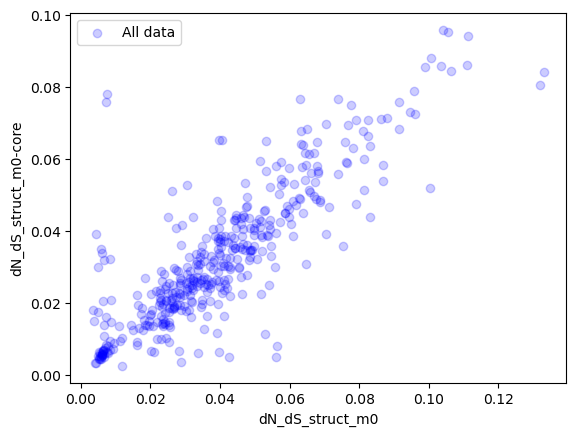

In [244]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' #'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

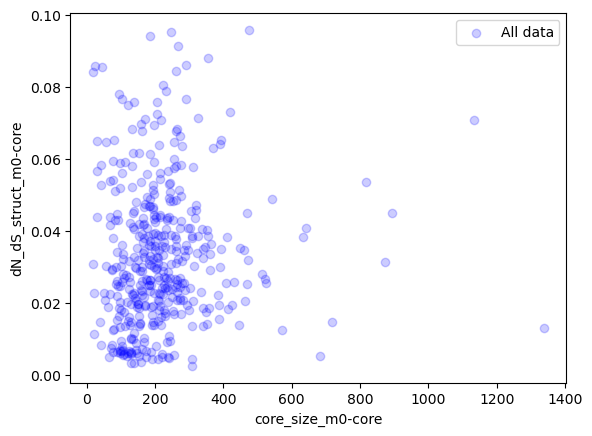

In [245]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = feature+'_size_m0-' + feature#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

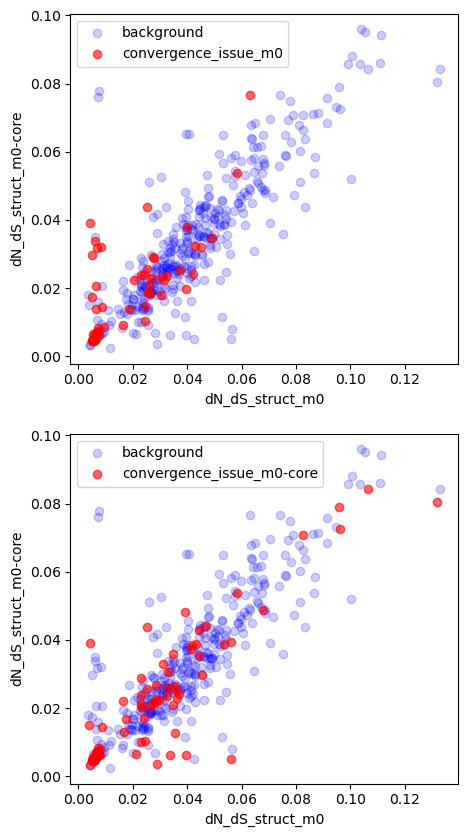

In [246]:
#dN/dS showing convergence issues

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, highlight in enumerate(['convergence_issue_m0', 'convergence_issue_m0-'+feature]):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data[dnds_struct_data[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data[dnds_struct_data[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [247]:
print('There are ' + str(sum((dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-' + feature]==False))) + ' ogs which have dN/dS calculated for the ' + feature + ' and no convergence issues either for the full protein or for the ' + feature + ' itself')

dnds_struct_data_conv_filt=dnds_struct_data[(dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-' + feature]==False)]
dnds_struct_data_conv_filt = dnds_struct_data_conv_filt.copy()

There are 305 ogs which have dN/dS calculated for the core and no convergence issues either for the full protein or for the core itself


In [248]:
#After filtering out convergence issue, filter out dS > 3 for both
dnds_struct_data_conv_filt['dS>3_m0-BS'] = (dnds_struct_data_conv_filt['dS_mean_m0-'+feature]>3)
print('There are ' + str(sum((dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-'+feature]==False))) + ' orthogroups with dnds calculated for ' + feature + ' that have dS<3 for both the ' + feature + ' and for the entire orthogroup')

dnds_struct_data_ds_filt = dnds_struct_data_conv_filt[(dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-' + feature]==False)]
dnds_struct_data_ds_filt = dnds_struct_data_ds_filt.copy()

There are 216 orthogroups with dnds calculated for core that have dS<3 for both the core and for the entire orthogroup


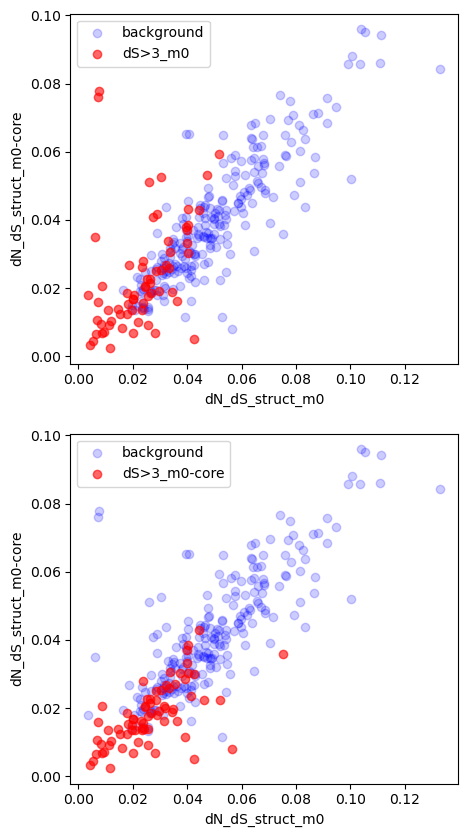

In [249]:
#dN/dS showing dS>3

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-'+feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_conv_filt

for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-' + feature]):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

Text(0.02, 0.08, 'R=0.88\np=1e-68')

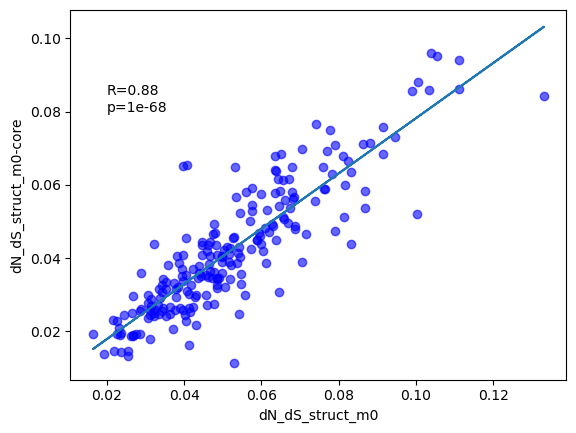

In [250]:
#dN/dS with all filters applied 

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_ds_filt

#for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
#    ax = axarr[jj]
#    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
#    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

#(data_to_plot, color, alpha, label) = dnds_background

(data_to_plot, color, alpha, label) = (dnds_struct_data_in, 'b',0.6,'all data')

#good to quantify r2 here
#for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
#ax.legend()

#add linear regression line to scatterplot for background
x_data = data_to_plot[x_value]
y_data = data_to_plot[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.text(0.02, 0.08, 'R={:.2}\np={:.1}'.format(r_value, p_value))

In [252]:
#Core more dN/dS than overall
#Core less dN/dS than overall
x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

x_data =  dnds_struct_data_ds_filt[x_value]
y_data =  dnds_struct_data_ds_filt[y_value]

gap = 0.018

columns = ['dN_dS_struct_m0-' + feature,'dN_dS_struct_m0', feature + '_size_m0-'+feature,'Mean(log2(Abundances)) 10 Sp [EXP]_m0', 'sc_uniprot_id', 'sc_gene_id','sc_genename']
dnds_struct_data_ds_filt[y_data>(slope*x_data)+gap].loc[:,columns]

,dN_dS_struct_m0-core,dN_dS_struct_m0,core_size_m0-core,Mean(log2(Abundances)) 10 Sp [EXP]_m0,sc_uniprot_id,sc_gene_id,sc_genename
OG3994_REF_Scer_AF-P04397-F1-model_v2,0.06519,0.03961,392,12.945071,P04397,YBR019C,GAL10
OG3909_REF_Scer_AF-P40319-F1-model_v2,0.06833,0.06506,131,NaN,P40319,YLR372W,ELO3
OG3505_REF_Scer_AF-P04037-F1-model_v2,0.06492,0.05319,30,16.611482,P04037,YGL187C,COX4
OG4312_REF_Scer_AF-P38115-F1-model_v2,0.06783,0.06338,161,15.192733,P38115,YBR149W,ARA1
OG1497_REF_Scer_AF-P38143-F1-model_v2,0.06533,0.04068,79,15.614844,P38143,YBR244W,GPX2
OG1979_REF_Scer_AF-P00445-F1-model_v2,0.04379,0.03215,68,19.097776,P00445,YJR104C,SOD1
OG1021_REF_Scer_AF-P40047-F1-model_v2,0.07667,0.07402,289,16.359878,P40047,YER073W,ALD5


In [253]:
#Core less dN/dS than overall
x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-' + feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

x_data =  dnds_struct_data_ds_filt[x_value]
y_data =  dnds_struct_data_ds_filt[y_value]

gap = 0.018

columns = ['dN_dS_struct_m0-' + feature,'dN_dS_struct_m0', feature+ '_size_m0-'+feature,'Mean(log2(Abundances)) 10 Sp [EXP]_m0', 'sc_uniprot_id', 'sc_gene_id','sc_genename']
dnds_struct_data_ds_filt[y_data<(slope*x_data)-gap].loc[:,columns]

,dN_dS_struct_m0-core,dN_dS_struct_m0,core_size_m0-core,Mean(log2(Abundances)) 10 Sp [EXP]_m0,sc_uniprot_id,sc_gene_id,sc_genename
OG3185_REF_Scer_AF-P00447-F1-model_v2,0.05196,0.10029,97,15.514008,P00447,YHR008C,SOD2
OG1254_REF_Scer_AF-Q01519-F1-model_v2,0.01143,0.05297,22,16.371573,Q01519,YLR038C,COX12
OG3208_REF_Scer_AF-P00128-F1-model_v2,0.04385,0.08318,31,15.685176,P00128,YDR529C,QCR7


In [ ]:
#dnds_struct_data_ds_filt_core = dnds_struct_data_ds_filt
#dnds_struct_data_ds_filt_surface = dnds_struct_data_ds_filt

In [254]:
dnds_struct_data_ds_filt_core_surface = dnds_struct_data_ds_filt_surface.merge(dnds_struct_data_ds_filt,how='outer',left_index=True, right_index=True)

In [223]:
#dnds_struct_data_ds_filt_core

In [255]:
dnds_struct_data_ds_filt_core_surface.columns

Index(['og_m0-surface', 'tree_length_m0-surface', 'kappa_m0-surface',
       'dN_dS_struct_m0-surface', 'tree_length_dN_m0-surface',
       'tree_length_dS_m0-surface', 'convergence_issue_m0-surface',
       'dN_dS_found_m0-surface', 'dN_mean_m0-surface', 'dN_std_m0-surface',
       'dS_mean_m0-surface', 'dS_std_m0-surface', 'surface_size_m0-surface',
       'og_m0_x', 'tree_length_m0_x', 'kappa_m0_x', 'dN_dS_struct_m0_x',
       'tree_length_dN_m0_x', 'tree_length_dS_m0_x', 'convergence_issue_m0_x',
       'dN_dS_found_m0_x', 'dN_mean_m0_x', 'dN_std_m0_x', 'dS_mean_m0_x',
       'dS_std_m0_x', 'dS>3_m0_x', 'dS>5_m0_x', 'dS>7.5_m0_x',
       'Mean(Conservation Rate) [ALL]_m0_x',
       'CV(Type Conservation Rate) [ALL]_m0_x',
       'Mean(Type Conservation Rate) [ALL]_m0_x',
       'CV(Conservation Rate) [ALL]_m0_x',
       'Mean(log2(Abundances)) 10 Sp [EXP]_m0_x',
       'Median(log2(Abundances)) 10 Sp [EXP]_m0_x',
       'Std(log2(Abundances)) 10 Sp [EXP]_m0_x',
       '1k_Mean_log2

Text(0.02, 0.08, 'R=0.89\np=6e-61')

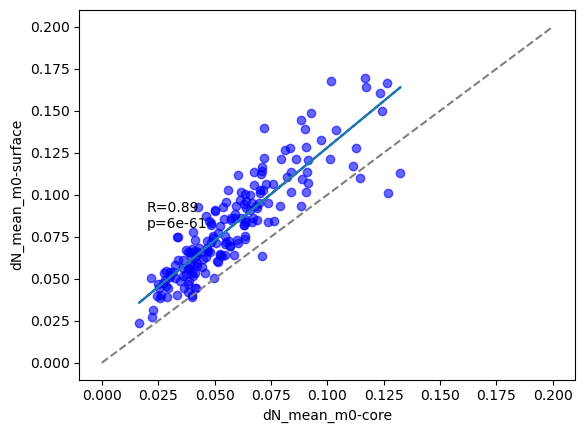

In [258]:
#dN/dS with all filters applied 

fig, ax = plt.subplots()

xlim = (0,0.2)

x_value = 'dN_mean_m0-core'#'dN_dS_struct_m0-core' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_mean_m0-surface' #'dN_dS_struct_m0-surface' #+ feature #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_ds_filt_core_surface

#for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
#    ax = axarr[jj]
#    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
#    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

#(data_to_plot, color, alpha, label) = dnds_background

(data_to_plot, color, alpha, label) = (dnds_struct_data_in, 'b',0.6,'all data')

#good to quantify r2 here
#for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
#ax.set_xlim(xlim)
#ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.plot(xlim,xlim,linestyle='--',c='grey')
#ax.legend()

#add linear regression line to scatterplot for background
x_data = data_to_plot[x_value]
y_data = data_to_plot[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]


m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.text(0.02, 0.08, 'R={:.2}\np={:.1}'.format(r_value, p_value))

In [184]:
dnds_struct_data_ds_filt_core_surface

,og_m0-core,tree_length_m0-core,kappa_m0-core,dN_dS_struct_m0-core,tree_length_dN_m0-core,tree_length_dS_m0-core,convergence_issue_m0-core,dN_dS_found_m0-core,dN_mean_m0-core,dN_std_m0-core,...,Mean(log2(Abundances)) 10 Sp [EXP]_m0_y,Median(log2(Abundances)) 10 Sp [EXP]_m0_y,Std(log2(Abundances)) 10 Sp [EXP]_m0_y,1k_Mean_log2_Abundances [EXP]_m0_y,sc_uniprot_id_y,sc_gene_id_y,sc_genename_y,surface_size,dS>3_m0-surface,dS>3_m0-BS_y
OG1004_REF_Scer_AF-P40459-F1-model_v2,OG1004,83.702381,1.15797,0.04195,4.0707,97.0368,False,True,0.090460,0.073456,...,13.224744,13.139869,0.973503,7.406555,P40459,YIL145C,PAN6,77.0,False,False
OG1016_REF_Scer_AF-P00330-F1-model_v2,OG1016,93.634261,1.56557,0.05124,5.2005,101.5010,False,True,0.040947,0.056215,...,17.374313,17.786900,2.354828,NaN,P00330,YOL086C,ADH1,125.0,False,False
OG1021_REF_Scer_AF-P40047-F1-model_v2,OG1021,72.730653,1.43142,0.07667,6.0995,79.5504,False,True,0.054947,0.053927,...,16.359878,16.525179,1.729851,7.103185,P40047,YER073W,ALD5,159.0,False,False
OG1022_REF_Scer_AF-P38715-F1-model_v2,OG1022,70.701208,1.46110,0.04692,4.0418,86.1337,False,True,0.064157,0.051509,...,15.828322,15.544385,1.211850,9.953869,P38715,YHR104W,GRE3,100.0,False,False
OG1022_REF_Scer_AF-P49954-F1-model_v2,OG1022,112.967624,1.49816,0.02499,3.4711,138.9095,False,True,0.073849,0.061649,...,15.828322,15.544385,1.211850,7.967152,P49954,YLR351C,NIT3,84.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG5096_REF_Scer_AF-P42883-F1-model_v2,OG5096,29.517184,1.16742,0.03209,1.2966,40.4087,False,True,0.030151,0.035127,...,11.672408,11.672408,NaN,NaN,P42883,YNL332W,THI12,115.0,False,False
OG5327_REF_Scer_AF-P43635-F1-model_v2,OG5327,51.329905,1.11325,0.02707,1.7288,63.8660,False,True,0.064026,0.036040,...,10.930296,10.930296,0.541612,NaN,P43635,YPR001W,CIT3,142.0,False,False
OG5404_REF_Scer_AF-P06115-F1-model_v2,OG5404,27.325809,1.16707,0.05080,1.8969,37.3410,False,True,0.075876,0.065107,...,13.509042,13.741165,1.616523,NaN,P06115,YGR088W,CTT1,173.0,False,False
OG5441_REF_Scer_AF-P00724-F1-model_v2,OG5441,35.115296,1.32188,0.08608,3.3944,39.4320,False,True,0.117045,0.082589,...,14.778412,14.746981,1.179589,NaN,P00724,YIL162W,SUC2,106.0,False,False


## Breakdown Residue Class (from site-model calculations) by structural feature

In [ ]:


#load residue class data

# Load NEB and BEB tables for each orthogroup.  If loading from raw files, save them as a .csv in appropriate og file. 

site_model_base = base_dir + os.sep + os.path.normpath('selection_calculations/site_model') + os.sep
site_model_data_dfs = dyt.load_site_model_data(site_model_base, branch_table_out=False)

posterior_data = {}

for og_ref in next(os.walk(site_model_base))[1]:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
    #         ##for og_ref in tm_align_post_trim_filter_list:
    #og_ref = 'OG4555_REF_Scer_AF-P32799-F1-model_v2'  #example
    og = og_ref.split('_')[0]
    if og[0:2] =='OG':
        posterior_data_og = {}
        for site_class in ['NEB_2']: #, 'NEB_3', 'BEB_3']:
            posterior_data_og[site_class] = pd.read_csv(site_model_base + os.sep + og_ref + os.sep + site_class + '.csv', index_col=0)
        posterior_data[og_ref] = posterior_data_og

#load residue feature data

surface_core_data_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/surface_core_data.json')
with open(surface_core_data_fname, 'r') as f:
    surface_core_data = json.load(f)



m0_dS_filter = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col=0)



In [4]:
og_ref = 'OG2197_REF_Scer_AF-P00942-F1-model_v2'
surface_core_pct_thresholds = (0.2, 0.8)

In [ ]:

# #map residues onto alignments
# paml_ref_residues = list(zip(posterior_data[og_ref]['NEB_2'].index, posterior_data[og_ref]['NEB_2']['residue_first_seq']))
# ref_res_of_int, aln_res_of_int, ref_seq = dyt.identify_ref_residue(og_ref, paml_ref_residues)


In [9]:
site_model_neutral_subset

,og,mle,tree_length_NearlyNeutral,kappa,p_1,dN_dS_1,p_2,dN_dS_2,convergence_issue_NearlyNeutral,dN_dS_found,tree_length_M0,dN_dS_struct,Mean(Conservation Rate) [ALL],Mean(log2(Abundances)) 10 Sp [EXP],convergence_issue_M0,dS>3
OG3774_REF_Scer_AF-P32377-F1-model_v2,OG3774,-20203.219487,38.591033,1.53866,0.78232,0.05898,0.21768,1.0,False,True,71.988980,0.03719,0.667632,15.076857,False,False
OG1240_REF_Scer_AF-P30624-F1-model_v2,OG1240,-45249.060656,45.921611,1.55482,0.79133,0.09456,0.20867,1.0,False,True,63.985500,0.06339,0.587139,14.927815,False,False
OG1287_REF_Scer_AF-P37298-F1-model_v2,OG1287,-9452.998496,52.249091,1.46258,0.93817,0.12006,0.06183,1.0,False,True,97.455808,0.05334,0.469603,NaN,False,False
OG1537_REF_Scer_AF-P32288-F1-model_v2,OG1537,-18188.014107,24.682265,1.67808,0.86400,0.05214,0.13600,1.0,True,True,27.679991,0.05975,0.800083,16.126006,False,False
OG1685_REF_Scer_AF-P07991-F1-model_v2,OG1685,-21054.999783,33.919902,1.79600,0.89096,0.05170,0.10904,1.0,False,True,61.614481,0.03269,0.689065,15.192938,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG4275_REF_Scer_AF-P32451-F1-model_v2,OG4275,-13445.232784,32.711639,1.19594,0.95063,0.04927,0.04937,1.0,False,True,55.658033,0.02678,0.715380,12.258027,False,False
OG2098_REF_Scer_AF-P32462-F1-model_v2,OG2098,-25586.685828,58.429241,1.41843,0.83896,0.06993,0.16104,1.0,False,True,103.009113,0.03714,0.618560,NaN,False,False
OG1899_REF_Scer_AF-P09950-F1-model_v2,OG1899,-24855.026385,50.398401,1.33037,0.89812,0.04182,0.10188,1.0,False,True,73.577492,0.02868,0.709513,12.149427,False,False
OG1264_REF_Scer_AF-P52892-F1-model_v2,OG1264,-34182.430659,44.426117,1.78911,0.79105,0.09287,0.20895,1.0,False,True,53.762643,0.08101,0.593479,14.194870,False,False


In [10]:
#Surface/core
#
#get surface core percentage for trimmed alignment

site_model_data_dfs_neutral = site_model_data_dfs['NearlyNeutral'].copy()
site_model_data_dfs_neutral = site_model_data_dfs_neutral.loc[site_model_data_dfs_neutral['dN_dS_found'],:]
site_model_neutral_merged = site_model_data_dfs_neutral.merge(m0_dS_filter.loc[:,['tree_length','dN_dS_struct', 'Mean(Conservation Rate) [ALL]', 'Mean(log2(Abundances)) 10 Sp [EXP]', 'convergence_issue', 'dS>3']], left_index=True, right_index=True, how='inner', suffixes=['_NearlyNeutral', '_M0'])
site_model_neutral_merged_rm_na = site_model_neutral_merged.loc[~site_model_neutral_merged['dS>3'].isna(),:] # for some reason one og has M0 as NaN, but not site model OG1357_REF_Scer_AF-P14742-F1-model_v2
site_model_neutral_subset = site_model_neutral_merged_rm_na.loc[(~(site_model_neutral_merged_rm_na['dS>3'].astype('bool')) & ~(site_model_neutral_merged_rm_na['convergence_issue_M0'].astype('bool'))),:]


mean_core_column_pct = {}

for og_ref in site_model_neutral_subset.index:

    og_surface_core_data = surface_core_data[og_ref]

    aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
    aln = AlignIO.read(open(aln_fname),'fasta')

    core_column_pct_untrimmed, column_occupancy_untrimmed, surface_core_aligned_mat_untrimmed, record_order_untrimmed = dyt.surface_core_analysis_alignment(aln, og_surface_core_data)

    #For each trimmed alignment extract percentage core/surface for each column in the alignment.  
    aln_trim_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trim_strict/' + og_ref + '.tm.fasta.clipkit')

    core_column_pct, column_occupancy, surface_core_aligned_mat, record_order = dyt.surface_core_analysis_untrimmed_to_trimmed(aln_trim_fname,surface_core_aligned_mat_untrimmed)


    core_column_pct_by_class = {1:[],2:[]}
    for jj, residue_class in enumerate(posterior_data[og_ref]['NEB_2']['class']):
        if residue_class==1:
            core_column_pct_by_class[1].append(core_column_pct[jj])
        elif residue_class==2:
            core_column_pct_by_class[2].append(core_column_pct[jj])

    mean_core_column_pct_og = {1: np.mean(core_column_pct_by_class[1]), 
                               2: np.mean(core_column_pct_by_class[2])
                               }
    
    mean_core_column_pct[og_ref] = mean_core_column_pct_og

alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core residues - may be empty
alignment column has no surface or core 

Text(0, 0.5, 'Avg over orthogroups of fraction of columns classified as surface')

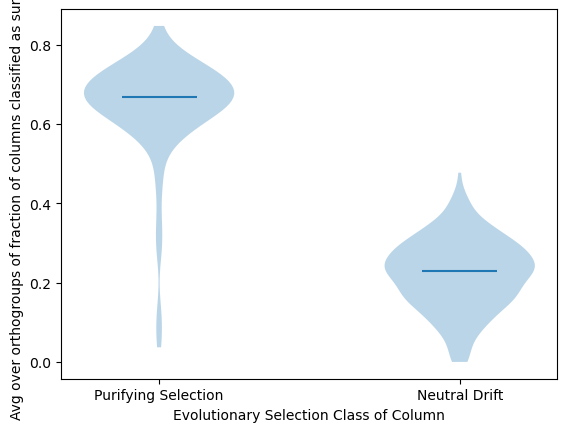

In [26]:
mean_core_column_pct_df = pd.DataFrame.from_dict(mean_core_column_pct, orient='index')

mean_core_column_pct_df.columns = ['Purifying Selection', 'Neutral Drift']


#
fig, ax = plt.subplots()

ax.violinplot(mean_core_column_pct_df, showmedians=True,showextrema=False)

ax.set_xticks([1,2], labels = mean_core_column_pct_df.columns)
ax.set_xlabel('Evolutionary Selection Class of Column')
ax.set_ylabel('Avg over orthogroups of fraction of columns classified as surface')




(array([ 44.,   8.,   3.,   0.,   0.,   1.,   2.,   2.,   2., 117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

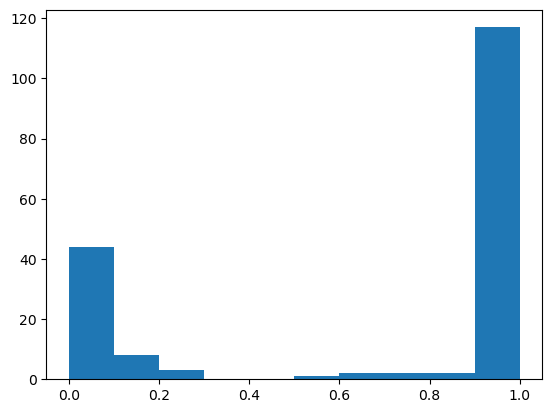

In [35]:
plt.hist(core_column_pct_by_class[1])

(array([36.,  3.,  2.,  2.,  3.,  2.,  4.,  1.,  3., 12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

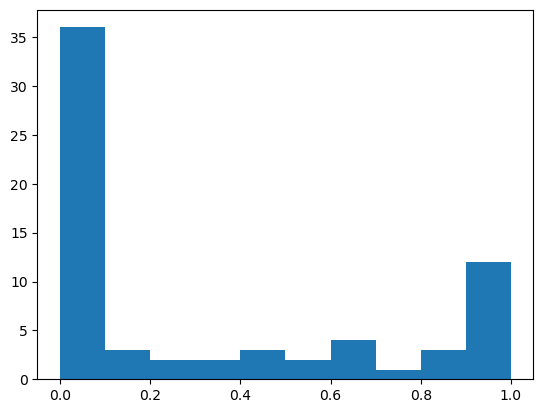

In [36]:
plt.hist(core_column_pct_by_class[2])

In [ ]:
['protein_data'].keys()

dict_keys(['Calb_AF-Q9P940-F1-model_v2', 'REF_Scer_AF-P00942-F1-model_v2', 'Spom_AF-P07669-F1-model_v2', 'alloascoidea_hylecoeti__OG2197__0_8057', 'ascoidea_rubescens__OG2197__6_4895', 'candida_apicola__OG2197__13_218', 'candida_tropicalis__OG2197__30_2948', 'cyberlindnera_jadinii__OG2197__35_4289', 'debaryomyces_hansenii__OG2197__36_4075', 'eremothecium_gossypii__OG2197__40_1063', 'geotrichum_candidum__OG2197__43_3116', 'kazachstania_naganishii__OG2197__49_915', 'kluyveromyces_lactis__OG2197__50_3792', 'kluyveromyces_marxianus__OG2197__51_4114', 'komagataella_pastoris__OG2197__52_964', 'lachancea_thermotolerans__OG2197__64_3503', 'lipomyces_starkeyi__OG2197__66_6013', 'ogataea_parapolymorpha__OG2197__104_3318', 'pachysolen_tannophilus__OG2197__106_5301', 'tortispora_caseinolytica__OG2197__134_3081', 'torulaspora_delbrueckii__OG2197__135_2379', 'vanderwaltozyma_polyspora__OG2197__136_1375', 'wickerhamomyces_anomalus__OG2197__139_3416', 'yHMPu5000034604_sporopachydermia_lactativora_1605